<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (n, n) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (n * m, n)
        m, n = X.shape
        q = compute_q(p)
        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", m, n)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", n*m)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_scale_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_scale_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        if np.sum(S_mis * S_mis) == 0:
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        elif S_mis.shape == (m, n, n):
          S_dts_tiled = np.concatenate([S_dts] * m)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (n * m, n):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_scale_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_scale_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=4, n_deltas_mis=4):
    _, m = X.shape
    amin = eps_amax * amax
    dts_min = eps_dts_max * dts_max
    if np.all(S_dict['S_mis'] == 0):
      print("no missing part in get path")
      n_deltas_mis = 1
      alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    print("n_delta_miss in get path ", n_deltas_mis)
    mis_min = eps_mis_max * mis_max
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    dts_deltas = np.logspace(np.log10(dts_min), np.log10(dts_max), n_deltas_dts)
    mis_deltas = np.logspace(np.log10(mis_min), np.log10(mis_max), n_deltas_mis)
    print("dts deltas ", dts_deltas)
    print("mis deltas ", mis_deltas)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, 1e3, 1e0, 1e0, S_dict)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [33]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [44]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [30]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
    else:
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      X_train = np.concatenate(X_imputed)
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    #dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) * dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  * dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing}  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha, best_delta_dts, best_delta_mis = best_hyper_p[0], best_hyper_p[1], best_hyper_p[2]
      print("best alpha ----> ", best_alpha)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = (S_dict['S_dts'] * best_delta_dts + S_dict['S_mis'] * best_delta_mis) * best_alpha
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha, coef_dts, coef_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [34]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed = dict_obser = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0])
      mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = mask_no_both_seen.shape[0]
        mask_partial = mask_no_both_seen.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}}  # add an entry for imputed dataset
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
n_tot :  20050
n_train :  50
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9975062344139651
err :  {'type': 'Gaussian_on_y', 'scaling': 1}
plots :  []
p_miss :  [0.9, 0.04999999999999999, 0.04999999999999999]
generation :  f
title_infer_error :   
title_test_error :   
[{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}]
imp_method :  BR_si
cov_strategy :  std_nan
multip_dataset :  3
multip_missing :  0
imp_method :  oracle
cov_strategy :  sd
mult

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:00<00:01, 51.76it/s]

 12%|█▏        | 12/100 [00:00<00:01, 51.75it/s]

 18%|█▊        | 18/100 [00:00<00:01, 54.11it/s]

 26%|██▌       | 26/100 [00:00<00:01, 62.46it/s]

 35%|███▌      | 35/100 [00:00<00:00, 70.80it/s]

 43%|████▎     | 43/100 [00:00<00:00, 73.37it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 77.12it/s]

 60%|██████    | 60/100 [00:00<00:00, 72.59it/s]

 70%|███████   | 70/100 [00:00<00:00, 79.40it/s]

 79%|███████▉  | 79/100 [00:01<00:00, 78.07it/s]

 88%|████████▊ | 88/100 [00:01<00:00, 80.59it/s]

100%|██████████| 100/100 [00:01<00:00, 71.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 62.33it/s]

 14%|█▍        | 14/100 [00:00<00:01, 59.79it/s]

 21%|██        | 21/100 [00:00<00:01, 63.20it/s]

 32%|███▏      | 32/100 [00:00<00:00, 77.01it/s]

 42%|████▏     | 42/100 [00:00<00:00, 84.

best alpha ---->  4.132012400115339
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  40  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.1320124e+00 1.0000000e-03 1.0000000e-03] , min score  1.041402587841387
---------------------------------> best coeff  [-0.24215624  1.88818601]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.48it/s]

 45%|████▌     | 45/100 [00:00<00:00, 228.73it/s]

 71%|███████   | 71/100 [00:00<00:00, 242.43it/s]

100%|██████████| 100/100 [00:00<00:00, 243.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 274.44it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 274.11it/s]

100%|██████████| 100/100 [00:00<00:00, 268.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [00:00<00:00, 282.96it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 271.72it/s]

100%|██████████| 100/100 [00:00<00:00, 253.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 270.36it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 255.23it/s]

100%|██████████| 100/100 [00:00<00:00, 250.53it/s]

100%|████████

best alpha ---->  4.5348785081285845
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  41  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.53487851e+00 1.00000000e-03 1.00000000e-03] , min score  1.0349833765658751
---------------------------------> best coeff  [-0.25906954  1.85858913]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 203.77it/s]

 48%|████▊     | 48/100 [00:00<00:00, 239.40it/s]

100%|██████████| 100/100 [00:00<00:00, 236.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 258.30it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 265.85it/s]

100%|██████████| 100/100 [00:00<00:00, 262.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 262.74it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 261.02it/s]

100%|██████████| 100/100 [00:00<00:00, 260.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 273.36it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 249.99it/s]

100%|██████████| 100/100 [00:00<00:00, 254.31it/s]

100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245406580650758
---------------------------------> best coeff  [-0.29510128  1.88878384]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  29.5132501783044
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.10052765 0.        ]
 [0.         3.19712675]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.98it/s]

 30%|███       | 30/100 [00:00<00:00, 149.57it/s]

 48%|████▊     | 48/100 [00:00<00:00, 161.22it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 164.62it/s]

100%|██████████| 100/100 [00:00<00:00, 164.98it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.64it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.13it/s]

 36%|███▌      | 36/100 [00:00<00:00, 170.16it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 172.21it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 175.09it/s]

100%|██████████| 100/100 [00:00<00:00, 168.38it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.65it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.58it/s]

 36%|███▌      | 36/100 [00:00<00:00, 166.60it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 169.51it/s]

 71%|███████   | 71/100 [00:00<00:00, 169.57it/s]

100%|██████████| 100/100 [00

best alpha ---->  2.5950242113997373
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  135  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.59502421e+00 1.00000000e-03 1.00000000e-02] , min score  1.047607928494081
---------------------------------> best coeff  [-0.22207865  1.86173473]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -0.1705218174448533
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.31it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.58it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 170.27it/s]

 70%|███████   | 70/100 [00:00<00:00, 167.88it/s]

100%|██████████| 100/100 [00:00<00:00, 163.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.72it/s]

 33%|███▎      | 33/100 [00:00<00:00, 161.42it/s]

 50%|█████     | 50/100 [00:00<00:00, 155.48it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 158.13it/s]

100%|██████████| 100/100 [00:00<00:00, 158.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.31it/s]

 34%|███▍      | 34/100 [00:00<00:00, 158.81it/s]

 51%|█████     | 51/100 [00:00<00:00, 163.48it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 184.35it/s]

100%|██████████| 100/100 [00:00<00:00, 188.9

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0226575447260284
---------------------------------> best coeff  [-0.30263955  1.90156413]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.53it/s]

 50%|█████     | 50/100 [00:00<00:00, 247.42it/s]

100%|██████████| 100/100 [00:00<00:00, 255.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 269.51it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 258.78it/s]

100%|██████████| 100/100 [00:00<00:00, 251.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 257.73it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 261.60it/s]

100%|██████████| 100/100 [00:00<00:00, 254.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [00:00<00:00, 274.75it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 263.17it/s]

100%|██████████| 100/100 [00:00<00:00, 250.40it/s]

100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


best alpha ---->  4.5348785081285845
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  41  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.53487851e+00 1.00000000e-03 1.00000000e-03] , min score  1.0349833765658751
---------------------------------> best coeff  [-0.25906954  1.85858913]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 219.89it/s]

 50%|█████     | 50/100 [00:00<00:00, 252.74it/s]

100%|██████████| 100/100 [00:00<00:00, 255.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [00:00<00:00, 265.19it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 267.63it/s]

100%|██████████| 100/100 [00:00<00:00, 265.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 253.23it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 227.14it/s]

100%|██████████| 100/100 [00:00<00:00, 246.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 258.83it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 263.76it/s]

100%|██████████| 100/100 [00:00<00:00, 259.60it/s]

100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245406580650758
---------------------------------> best coeff  [-0.29510128  1.88878384]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -0.7791844007523325
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83920212 0.        ]
 [0.         3.20823573]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.88it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.00it/s]

 50%|█████     | 50/100 [00:00<00:00, 167.87it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 160.17it/s]

100%|██████████| 100/100 [00:00<00:00, 164.18it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.01it/s]

 34%|███▍      | 34/100 [00:00<00:00, 157.77it/s]

 51%|█████     | 51/100 [00:00<00:00, 162.44it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 168.83it/s]

100%|██████████| 100/100 [00:00<00:00, 164.47it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.63it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.14it/s]

 32%|███▏      | 32/100 [00:00<00:00, 127.03it/s]

 49%|████▉     | 49/100 [00:00<00:00, 142.30it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 154.04it/s]

 83%|████████▎ | 83/100 [00:

best alpha ---->  0.2104904144512021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  608  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.21049041 0.01       0.1       ] , min score  1.03110356188727
---------------------------------> best coeff  [-0.27172712  1.87060239]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  6.836105307086621
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.30it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.98it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 167.87it/s]

 71%|███████   | 71/100 [00:00<00:00, 166.30it/s]

100%|██████████| 100/100 [00:00<00:00, 164.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.43it/s]

 38%|███▊      | 38/100 [00:00<00:00, 170.50it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 153.15it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 152.00it/s]

100%|██████████| 100/100 [00:00<00:00, 155.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.58it/s]

 35%|███▌      | 35/100 [00:00<00:00, 178.63it/s]

 61%|██████    | 61/100 [00:00<00:00, 214.72it/s]

100%|██████████| 100/100 [00:00<00:00, 217.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

best alpha ---->  0.7054802310718644
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  121  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.70548023 0.01       0.001     ] , min score  1.008556314314916
---------------------------------> best coeff  [-0.39215289  1.88294074]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.85it/s]

 47%|████▋     | 47/100 [00:00<00:00, 236.67it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 243.51it/s]

100%|██████████| 100/100 [00:00<00:00, 239.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 237.44it/s]

 49%|████▉     | 49/100 [00:00<00:00, 240.12it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 229.91it/s]

100%|██████████| 100/100 [00:00<00:00, 227.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 227.03it/s]

 48%|████▊     | 48/100 [00:00<00:00, 239.46it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 237.67it/s]

100%|██████████| 100/100 [00:00<00:00, 235.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 257.52it/s]

 52%|█████▏   

best alpha ---->  4.5348785081285845
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  41  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.53487851e+00 1.00000000e-03 1.00000000e-03] , min score  1.0349833765658751
---------------------------------> best coeff  [-0.25906954  1.85858913]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 216.64it/s]

 48%|████▊     | 48/100 [00:00<00:00, 237.88it/s]

100%|██████████| 100/100 [00:00<00:00, 247.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 228.60it/s]

 49%|████▉     | 49/100 [00:00<00:00, 241.00it/s]

100%|██████████| 100/100 [00:00<00:00, 248.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 219.90it/s]

 44%|████▍     | 44/100 [00:00<00:00, 218.32it/s]

 70%|███████   | 70/100 [00:00<00:00, 236.69it/s]

100%|██████████| 100/100 [00:00<00:00, 231.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [00:00<00:00, 256.89it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 260.14it/s]

100%|██████████| 100/100 [00:00<00:00, 257.22it/s]

100%|████████

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245406580650758
---------------------------------> best coeff  [-0.29510128  1.88878384]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  142.77021569373002
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.85237287 0.        ]
 [0.         3.18632291]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.22it/s]

 34%|███▍      | 34/100 [00:00<00:00, 164.58it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.61it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 170.27it/s]

100%|██████████| 100/100 [00:00<00:00, 164.92it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.64it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.89it/s]

 34%|███▍      | 34/100 [00:00<00:00, 164.84it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.40it/s]

 71%|███████   | 71/100 [00:00<00:00, 173.63it/s]

100%|██████████| 100/100 [00:00<00:00, 168.93it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.66it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.22it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.41it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 169.32it/s]

 70%|███████   | 70/100 [00:00<00:00, 158.68it/s]

100%|██████████| 100/100 [00

best alpha ---->  7.924828983539178
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  47  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.92482898e+00 1.00000000e-03 1.00000000e-03] , min score  1.0069429978112407
---------------------------------> best coeff  [-0.37892476  1.92087477]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  8.778556603356586
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.83it/s]

 31%|███       | 31/100 [00:00<00:00, 155.72it/s]

 47%|████▋     | 47/100 [00:00<00:00, 153.03it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 156.59it/s]

 81%|████████  | 81/100 [00:00<00:00, 158.80it/s]

100%|██████████| 100/100 [00:00<00:00, 157.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.47it/s]

 38%|███▊      | 38/100 [00:00<00:00, 169.22it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 162.83it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 157.50it/s]

100%|██████████| 100/100 [00:00<00:00, 157.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.93it/s]

 31%|███       | 31/100 [00:00<00:00, 150.40it/s]

 51%|█████     | 51/100 [00:00<00:00, 172.08it/s]

100%|██████████| 100/100 [00:00<00:00, 196.6

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  107  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.01       0.001     ] , min score  1.029553118355171
---------------------------------> best coeff  [-0.29219933  1.82029897]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.06599049 0.        ]
 [0.         3.18185787]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.15it/s]

 46%|████▌     | 46/100 [00:00<00:00, 229.84it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 241.09it/s]

100%|██████████| 100/100 [00:00<00:00, 232.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 216.02it/s]

 49%|████▉     | 49/100 [00:00<00:00, 246.36it/s]

100%|██████████| 100/100 [00:00<00:00, 250.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.36it/s]

 47%|████▋     | 47/100 [00:00<00:00, 236.89it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 245.67it/s]

100%|██████████| 100/100 [00:00<00:00, 235.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 239.64it/s]

 48%|████▊     | 48/100 [00:00<00:00, 239.63it/s]

 74%|███████▍ 

best alpha ---->  4.5348785081285845
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  41  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.53487851e+00 1.00000000e-03 1.00000000e-03] , min score  1.0349833765658751
---------------------------------> best coeff  [-0.25906954  1.85858913]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  -1.8964596770398976
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.80it/s]

 39%|███▉      | 39/100 [00:00<00:00, 202.01it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 236.66it/s]

100%|██████████| 100/100 [00:00<00:00, 230.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 242.75it/s]

 50%|█████     | 50/100 [00:00<00:00, 245.89it/s]

100%|██████████| 100/100 [00:00<00:00, 254.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 232.94it/s]

 49%|████▉     | 49/100 [00:00<00:00, 240.40it/s]

100%|██████████| 100/100 [00:00<00:00, 242.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:00<00:00, 243.04it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 256.44it/s]

100%|██████████| 100/100 [00:00<00:00, 251.75it/s]

100%|████████

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245406580650758
---------------------------------> best coeff  [-0.29510128  1.88878384]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02199683 1.06061929]
crush test------------------------------------------------->  294.7967893611823
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.84892869 0.        ]
 [0.         3.24212003]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.08it/s]

 31%|███       | 31/100 [00:00<00:00, 152.00it/s]

 47%|████▋     | 47/100 [00:00<00:00, 147.40it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 158.27it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 164.75it/s]

100%|██████████| 100/100 [00:00<00:00, 157.99it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.57it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.16it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.65it/s]

 46%|████▌     | 46/100 [00:00<00:00, 155.26it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 160.99it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 165.08it/s]

100%|██████████| 100/100 [00:00<00:00, 156.18it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.56it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.84it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.27it/s]

 51%|█████     | 51/100 [00:

best alpha ---->  0.2535364493970112
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  110  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.25353645 0.001      0.01      ] , min score  1.1613311945870235
---------------------------------> best coeff  [-0.00742817  1.62116678]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.24215624,  1.88818601]), array([-0.30263955,  1.90156413]), array([-0.39215289,  1.88294074]), array([-0.29219933,  1.82029897])], 'l2_dist_best_coeff_gt': [np.float64(0.2810440805824584), np.float64(0.22054652260581986), np.float64(0.15916617182367176), np.float64(0.2747245451910148)], 'best_score': [np.float64(1.041402587841387), np.float64(1.0226575447260284), np.float64(1.008556314314916), np.float64(1.029553118355171)], 'best_alpha': [np.float64(-0.6161616161616164), np.float64(0.2727272727272727), np.float64(0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.10it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.14it/s]

 44%|████▍     | 44/100 [00:00<00:00, 146.20it/s]

 60%|██████    | 60/100 [00:00<00:00, 151.36it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 160.53it/s]

100%|██████████| 100/100 [00:00<00:00, 149.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.03it/s]

 30%|███       | 30/100 [00:00<00:00, 133.69it/s]

 46%|████▌     | 46/100 [00:00<00:00, 144.67it/s]

 61%|██████    | 61/100 [00:00<00:00, 146.42it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 145.26it/s]

100%|██████████| 100/100 [00:00<00:00, 148.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 232.55it/s]

 49%|████▉     | 49/100 [00:00<00:00, 240.87it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 237.44

best alpha ---->  3.764935806792469
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.76493581e+00 1.00000000e-03 1.00000000e-03] , min score  1.0367287579889766
---------------------------------> best coeff  [-0.67075414  2.00011095]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41547707 0.        ]
 [0.         3.36096154]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 215.85it/s]

 47%|████▋     | 47/100 [00:00<00:00, 234.39it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 243.56it/s]

100%|██████████| 100/100 [00:00<00:00, 240.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.25it/s]

 42%|████▏     | 42/100 [00:00<00:00, 213.81it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 237.19it/s]

100%|██████████| 100/100 [00:00<00:00, 226.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [00:00<00:00, 237.62it/s]

 50%|█████     | 50/100 [00:00<00:00, 245.44it/s]

100%|██████████| 100/100 [00:00<00:00, 248.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 223.26it/s]

 49%|████▉     | 49/100 [00:00<00:00, 236.80it/s]

 73%|███████▎ 

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  207  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.1        0.001     ] , min score  1.027703125571956
---------------------------------> best coeff  [-0.43415263  1.82072807]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.95it/s]

 43%|████▎     | 43/100 [00:00<00:00, 215.53it/s]

 70%|███████   | 70/100 [00:00<00:00, 239.93it/s]

100%|██████████| 100/100 [00:00<00:00, 235.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 228.68it/s]

 49%|████▉     | 49/100 [00:00<00:00, 246.20it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 246.35it/s]

100%|██████████| 100/100 [00:00<00:00, 239.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.93it/s]

 44%|████▍     | 44/100 [00:00<00:00, 223.90it/s]

 70%|███████   | 70/100 [00:00<00:00, 240.05it/s]

100%|██████████| 100/100 [00:00<00:00, 233.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 215.76it/s]

 48%|████▊    

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0190144527829879
---------------------------------> best coeff  [-0.58618856  1.96709583]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -391.6131828570204
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.36912906 0.        ]
 [0.         3.43320512]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.09it/s]

 30%|███       | 30/100 [00:00<00:00, 149.62it/s]

 47%|████▋     | 47/100 [00:00<00:00, 157.01it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 148.48it/s]

 80%|████████  | 80/100 [00:00<00:00, 153.62it/s]

100%|██████████| 100/100 [00:00<00:00, 151.98it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.51it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.42it/s]

 32%|███▏      | 32/100 [00:00<00:00, 158.24it/s]

 49%|████▉     | 49/100 [00:00<00:00, 161.54it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 161.71it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 162.27it/s]

100%|██████████| 100/100 [00:00<00:00, 160.55it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.55it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.69it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.91it/s]

 44%|████▍     | 44/100 [00:

best alpha ---->  0.4430621457583881
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  516  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.44306215 0.01       0.01      ] , min score  1.034616264191134
---------------------------------> best coeff  [-0.66679888  2.00432009]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -7.702052095970645
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.56it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.40it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 169.15it/s]

 70%|███████   | 70/100 [00:00<00:00, 157.16it/s]

100%|██████████| 100/100 [00:00<00:00, 158.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.35it/s]

 30%|███       | 30/100 [00:00<00:00, 136.70it/s]

 44%|████▍     | 44/100 [00:00<00:00, 131.83it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 152.40it/s]

100%|██████████| 100/100 [00:00<00:00, 170.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 205.27it/s]

 42%|████▏     | 42/100 [00:00<00:00, 200.76it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 221.28it/s]

100%|██████████| 100/100 [00:00<00:00, 218.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

best alpha ---->  10.476157527896651
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.04761575e+01 1.00000000e-03 1.00000000e-03] , min score  1.038615331040285
---------------------------------> best coeff  [-0.68026111  2.00756813]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41547707 0.        ]
 [0.         3.36096154]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.96it/s]

 37%|███▋      | 37/100 [00:00<00:00, 185.63it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 218.96it/s]

100%|██████████| 100/100 [00:00<00:00, 222.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.48it/s]

 47%|████▋     | 47/100 [00:00<00:00, 235.63it/s]

 71%|███████   | 71/100 [00:00<00:00, 230.34it/s]

100%|██████████| 100/100 [00:00<00:00, 227.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.21it/s]

 46%|████▌     | 46/100 [00:00<00:00, 231.10it/s]

 70%|███████   | 70/100 [00:00<00:00, 219.01it/s]

100%|██████████| 100/100 [00:00<00:00, 221.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.06it/s]

 46%|████▌    

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  207  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.1        0.001     ] , min score  1.027703125571956
---------------------------------> best coeff  [-0.43415263  1.82072807]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.53it/s]

 44%|████▍     | 44/100 [00:00<00:00, 222.75it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 217.68it/s]

100%|██████████| 100/100 [00:00<00:00, 221.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:00<00:00, 227.91it/s]

 48%|████▊     | 48/100 [00:00<00:00, 236.54it/s]

100%|██████████| 100/100 [00:00<00:00, 248.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.20it/s]

 49%|████▉     | 49/100 [00:00<00:00, 244.02it/s]

100%|██████████| 100/100 [00:00<00:00, 250.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.72it/s]

 42%|████▏     | 42/100 [00:00<00:00, 215.45it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 237.13it/s]

100%|█████████

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0190144527829879
---------------------------------> best coeff  [-0.58618856  1.96709583]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -233.2937687314223
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.26894097 0.        ]
 [0.         3.47590015]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.53it/s]

 30%|███       | 30/100 [00:00<00:00, 149.24it/s]

 47%|████▋     | 47/100 [00:00<00:00, 157.64it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 159.19it/s]

 81%|████████  | 81/100 [00:00<00:00, 161.14it/s]

100%|██████████| 100/100 [00:00<00:00, 156.71it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.56it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.88it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.38it/s]

 49%|████▉     | 49/100 [00:00<00:00, 153.86it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 155.16it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 160.07it/s]

100%|██████████| 100/100 [00:00<00:00, 157.27it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.56it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.11it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.85it/s]

 49%|████▉     | 49/100 [00:

best alpha ---->  7.220809018385467
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.22080902e+00 1.00000000e-03 1.00000000e-03] , min score  1.0377226292695436
---------------------------------> best coeff  [-0.67731718  2.00682706]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -11.805870391832414
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.59it/s]

 30%|███       | 30/100 [00:00<00:00, 152.26it/s]

 46%|████▌     | 46/100 [00:00<00:00, 153.15it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 157.81it/s]

 80%|████████  | 80/100 [00:00<00:00, 159.36it/s]

100%|██████████| 100/100 [00:00<00:00, 156.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.65it/s]

 37%|███▋      | 37/100 [00:00<00:00, 186.27it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 196.84it/s]

100%|██████████| 100/100 [00:00<00:00, 211.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 206.59it/s]

 46%|████▌     | 46/100 [00:00<00:00, 231.91it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 247.16it/s]

100%|██████████| 100/100 [00:00<00:00, 235.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

best alpha ---->  7.924828983539178
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  47  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.92482898e+00 1.00000000e-03 1.00000000e-03] , min score  1.0775998608834165
---------------------------------> best coeff  [-0.48836806  1.72192721]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41547707 0.        ]
 [0.         3.36096154]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.87it/s]

 44%|████▍     | 44/100 [00:00<00:00, 219.91it/s]

 70%|███████   | 70/100 [00:00<00:00, 237.86it/s]

100%|██████████| 100/100 [00:00<00:00, 229.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.58it/s]

 45%|████▌     | 45/100 [00:00<00:00, 223.89it/s]

 71%|███████   | 71/100 [00:00<00:00, 237.94it/s]

100%|██████████| 100/100 [00:00<00:00, 222.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.80it/s]

 47%|████▋     | 47/100 [00:00<00:00, 234.30it/s]

 71%|███████   | 71/100 [00:00<00:00, 235.32it/s]

100%|██████████| 100/100 [00:00<00:00, 231.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.74it/s]

 42%|████▏    

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  207  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.1        0.001     ] , min score  1.027703125571956
---------------------------------> best coeff  [-0.43415263  1.82072807]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.70it/s]

 45%|████▌     | 45/100 [00:00<00:00, 229.36it/s]

 70%|███████   | 70/100 [00:00<00:00, 237.89it/s]

100%|██████████| 100/100 [00:00<00:00, 231.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 208.25it/s]

 46%|████▌     | 46/100 [00:00<00:00, 232.16it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 240.72it/s]

100%|██████████| 100/100 [00:00<00:00, 236.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.99it/s]

 42%|████▏     | 42/100 [00:00<00:00, 211.39it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 234.02it/s]

100%|██████████| 100/100 [00:00<00:00, 229.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 209.05it/s]

 46%|████▌    

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0190144527829879
---------------------------------> best coeff  [-0.58618856  1.96709583]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -336.837382915975
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29069877 0.        ]
 [0.         3.63004722]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 132.61it/s]

 30%|███       | 30/100 [00:00<00:00, 145.70it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.03it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 158.87it/s]

 80%|████████  | 80/100 [00:00<00:00, 151.25it/s]

100%|██████████| 100/100 [00:00<00:00, 150.98it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.50it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.40it/s]

 31%|███       | 31/100 [00:00<00:00, 154.93it/s]

 47%|████▋     | 47/100 [00:00<00:00, 154.63it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 158.66it/s]

 81%|████████  | 81/100 [00:00<00:00, 161.22it/s]

100%|██████████| 100/100 [00:00<00:00, 155.91it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.53it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.18it/s]

 30%|███       | 30/100 [00:00<00:00, 138.96it/s]

 46%|████▌     | 46/100 [00:

best alpha ---->  0.40370172585965547
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  415  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.40370173 0.01       0.001     ] , min score  1.074776661410657
---------------------------------> best coeff  [-0.72256093  1.94340705]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -9.764545340395735
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.19it/s]

 38%|███▊      | 38/100 [00:00<00:00, 190.86it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 214.53it/s]

100%|██████████| 100/100 [00:00<00:00, 218.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 204.01it/s]

 46%|████▌     | 46/100 [00:00<00:00, 228.48it/s]

 71%|███████   | 71/100 [00:00<00:00, 235.05it/s]

100%|██████████| 100/100 [00:00<00:00, 228.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.44it/s]

 41%|████      | 41/100 [00:00<00:00, 210.34it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 227.68it/s]

100%|██████████| 100/100 [00:00<00:00, 221.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 21%|██        | 21/100 [00:00<00:00, 206.54it/s]

 45%|████▌    

best alpha ---->  0.4862601580065355
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  117  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.48626016 0.01       0.001     ] , min score  1.0938859549182776
---------------------------------> best coeff  [-0.51138589  1.70675736]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41547707 0.        ]
 [0.         3.36096154]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 98.17it/s]

 35%|███▌      | 35/100 [00:00<00:00, 182.99it/s]

 60%|██████    | 60/100 [00:00<00:00, 209.14it/s]

100%|██████████| 100/100 [00:00<00:00, 207.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.60it/s]

 43%|████▎     | 43/100 [00:00<00:00, 218.43it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 229.68it/s]

100%|██████████| 100/100 [00:00<00:00, 219.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.49it/s]

 42%|████▏     | 42/100 [00:00<00:00, 206.87it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 224.10it/s]

100%|██████████| 100/100 [00:00<00:00, 217.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.89it/s]

 42%|████▏     

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  207  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.1        0.001     ] , min score  1.027703125571956
---------------------------------> best coeff  [-0.43415263  1.82072807]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -15.843911508714694
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.93it/s]

 38%|███▊      | 38/100 [00:00<00:00, 196.35it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 223.13it/s]

100%|██████████| 100/100 [00:00<00:00, 217.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.62it/s]

 44%|████▍     | 44/100 [00:00<00:00, 219.25it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 231.68it/s]

100%|██████████| 100/100 [00:00<00:00, 227.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.58it/s]

 44%|████▍     | 44/100 [00:00<00:00, 223.37it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 215.23it/s]

100%|██████████| 100/100 [00:00<00:00, 219.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 198.38it/s]

 45%|████▌    

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0190144527829879
---------------------------------> best coeff  [-0.58618856  1.96709583]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13849236 1.12032051]
crush test------------------------------------------------->  -288.2665592202716
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.34639954 0.        ]
 [0.         3.76364496]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.46it/s]

 30%|███       | 30/100 [00:00<00:00, 147.88it/s]

 47%|████▋     | 47/100 [00:00<00:00, 157.58it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 150.48it/s]

 81%|████████  | 81/100 [00:00<00:00, 159.76it/s]

100%|██████████| 100/100 [00:00<00:00, 154.08it/s]

 25%|██▌       | 1/4 [00:00<00:01,  1.53it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.97it/s]

 30%|███       | 30/100 [00:00<00:00, 148.67it/s]

 47%|████▋     | 47/100 [00:00<00:00, 156.24it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 158.30it/s]

 80%|████████  | 80/100 [00:00<00:00, 157.15it/s]

100%|██████████| 100/100 [00:00<00:00, 154.39it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.53it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 129.63it/s]

 29%|██▉       | 29/100 [00:00<00:00, 138.24it/s]

 46%|████▌     | 46/100 [00:

best alpha ---->  3.764935806792469
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  139  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.76493581e+00 1.00000000e-03 1.00000000e-02] , min score  1.0755118039364733
---------------------------------> best coeff  [-0.67089867  1.87707264]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.67075414,  2.00011095]), array([-0.68026111,  2.00756813]), array([-0.48836806,  1.72192721]), array([-0.51138589,  1.70675736])], 'l2_dist_best_coeff_gt': [np.float64(0.17075417159542575), np.float64(0.18041991046091113), np.float64(0.27831596490036453), np.float64(0.2934636041266068)], 'best_score': [np.float64(1.0367287579889766), np.float64(1.038615331040285), np.float64(1.0775998608834165), np.float64(1.0938859549182776)], 'best_alpha': [np.float64(-0.5757575757575759), np.float64(-1.0202020202020203)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [00:00<00:00, 213.04it/s]

 45%|████▌     | 45/100 [00:00<00:00, 222.09it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 241.61it/s]

100%|██████████| 100/100 [00:00<00:00, 233.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.38it/s]

 38%|███▊      | 38/100 [00:00<00:00, 186.68it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 218.61it/s]

100%|██████████| 100/100 [00:00<00:00, 214.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.96it/s]

 41%|████      | 41/100 [00:00<00:00, 206.04it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 214.55it/s]

100%|██████████| 100/100 [00:00<00:00, 212.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.43it/s]

 42%|████▏    

best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  1.0318940700926003
---------------------------------> best coeff  [-0.63324913  1.93397285]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50453363 0.        ]
 [0.         3.12664125]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.38it/s]

 39%|███▉      | 39/100 [00:00<00:00, 199.84it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 216.63it/s]

100%|██████████| 100/100 [00:00<00:00, 217.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.98it/s]

 38%|███▊      | 38/100 [00:00<00:00, 190.28it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 217.36it/s]

100%|██████████| 100/100 [00:00<00:00, 214.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.18it/s]

 42%|████▏     | 42/100 [00:00<00:00, 210.30it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 209.85it/s]

100%|██████████| 100/100 [00:00<00:00, 214.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 196.35it/s]

 45%|████▌    

best alpha ---->  8.697490026177835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  48  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.69749003e+00 1.00000000e-03 1.00000000e-03] , min score  1.0334828944613594
---------------------------------> best coeff  [-0.62880228  1.92320923]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:32,  3.01it/s]

 26%|██▌       | 26/100 [00:00<00:00, 76.87it/s]

 50%|█████     | 50/100 [00:00<00:00, 125.45it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 164.39it/s]

100%|██████████| 100/100 [00:00<00:00, 131.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 188.15it/s]

 41%|████      | 41/100 [00:00<00:00, 205.57it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 229.43it/s]

100%|██████████| 100/100 [00:00<00:00, 226.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.96it/s]

 43%|████▎     | 43/100 [00:00<00:00, 215.76it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 234.22it/s]

100%|██████████| 100/100 [00:00<00:00, 227.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0436498715018072
---------------------------------> best coeff  [-0.68398517  1.96206402]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -291.2797110730299
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.50453363 0.        ]
 [0.         3.16441912]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.04it/s]

 26%|██▌       | 26/100 [00:00<00:00, 125.15it/s]

 43%|████▎     | 43/100 [00:00<00:00, 142.76it/s]

 60%|██████    | 60/100 [00:00<00:00, 150.51it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 153.73it/s]

100%|██████████| 100/100 [00:00<00:00, 146.91it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.46it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.66it/s]

 29%|██▉       | 29/100 [00:00<00:00, 136.99it/s]

 44%|████▍     | 44/100 [00:00<00:00, 139.66it/s]

 61%|██████    | 61/100 [00:00<00:00, 148.07it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 153.85it/s]

100%|██████████| 100/100 [00:00<00:00, 148.79it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.90it/s]

 31%|███       | 31/100 [00:00<00:00, 150.89it/s]

 47%|████▋     | 47/100 [00:

best alpha ---->  1.2328467394420666
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  527  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.23284674 0.01       0.01      ] , min score  1.0303474729104405
---------------------------------> best coeff  [-0.62778207  1.93260897]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.806795081330684
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.32it/s]

 31%|███       | 31/100 [00:00<00:00, 153.00it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.42it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 191.57it/s]

100%|██████████| 100/100 [00:00<00:00, 188.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.81it/s]

 42%|████▏     | 42/100 [00:00<00:00, 212.00it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 226.25it/s]

100%|██████████| 100/100 [00:00<00:00, 220.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.56it/s]

 40%|████      | 40/100 [00:00<00:00, 200.74it/s]

 61%|██████    | 61/100 [00:00<00:00, 199.07it/s]

100%|██████████| 100/100 [00:00<00:00, 208.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋       

best alpha ---->  0.33516026509388425
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  213  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.33516027 0.1        0.001     ] , min score  1.0269230224775883
---------------------------------> best coeff  [-0.38210916  1.77854233]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50453363 0.        ]
 [0.         3.12664125]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.67it/s]

 38%|███▊      | 38/100 [00:00<00:00, 191.77it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 210.76it/s]

100%|██████████| 100/100 [00:00<00:00, 208.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.10it/s]

 40%|████      | 40/100 [00:00<00:00, 196.39it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 222.39it/s]

100%|██████████| 100/100 [00:00<00:00, 215.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.69it/s]

 45%|████▌     | 45/100 [00:00<00:00, 224.94it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 215.10it/s]

100%|██████████| 100/100 [00:00<00:00, 216.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.14it/s]

 43%|████▎    

best alpha ---->  8.697490026177835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  48  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.69749003e+00 1.00000000e-03 1.00000000e-03] , min score  1.0334828944613594
---------------------------------> best coeff  [-0.62880228  1.92320923]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.89it/s]

 44%|████▍     | 44/100 [00:00<00:00, 223.35it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 214.53it/s]

100%|██████████| 100/100 [00:00<00:00, 218.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.33it/s]

 45%|████▌     | 45/100 [00:00<00:00, 226.38it/s]

 71%|███████   | 71/100 [00:00<00:00, 237.27it/s]

100%|██████████| 100/100 [00:00<00:00, 231.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.62it/s]

 44%|████▍     | 44/100 [00:00<00:00, 221.67it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 228.11it/s]

100%|██████████| 100/100 [00:00<00:00, 220.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.54it/s]

 45%|████▌    

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0436498715018072
---------------------------------> best coeff  [-0.68398517  1.96206402]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -277.69412653951525
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.56166806 0.        ]
 [0.         3.28446006]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.18it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.69it/s]

 41%|████      | 41/100 [00:00<00:00, 137.02it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 137.12it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 142.75it/s]

100%|██████████| 100/100 [00:00<00:00, 143.05it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.42it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.91it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.46it/s]

 44%|████▍     | 44/100 [00:00<00:00, 143.46it/s]

 60%|██████    | 60/100 [00:00<00:00, 148.10it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 146.35it/s]

100%|██████████| 100/100 [00:00<00:00, 145.69it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.43it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.04it/s]

 27%|██▋       | 27/100 [00:00<00:00, 135.01it/s]

 43%|████▎     | 43/100 [00:

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  518  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.01      ] , min score  1.022879922550361
---------------------------------> best coeff  [-0.63073312  1.96591941]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -10.176344320455291
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.06it/s]

 43%|████▎     | 43/100 [00:00<00:00, 213.22it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 217.56it/s]

100%|██████████| 100/100 [00:00<00:00, 213.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.82it/s]

 37%|███▋      | 37/100 [00:00<00:00, 183.16it/s]

 60%|██████    | 60/100 [00:00<00:00, 203.55it/s]

100%|██████████| 100/100 [00:00<00:00, 205.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.33it/s]

 39%|███▉      | 39/100 [00:00<00:00, 190.26it/s]

 61%|██████    | 61/100 [00:00<00:00, 202.77it/s]

100%|██████████| 100/100 [00:00<00:00, 206.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.64it/s]

 36%|███▌     

best alpha ---->  7.220809018385467
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.22080902e+00 1.00000000e-03 1.00000000e-03] , min score  1.1317314263550804
---------------------------------> best coeff  [-0.45615637  1.60657324]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50453363 0.        ]
 [0.         3.12664125]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.48it/s]

 42%|████▏     | 42/100 [00:00<00:00, 211.69it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 224.15it/s]

100%|██████████| 100/100 [00:00<00:00, 217.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.00it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.86it/s]

 60%|██████    | 60/100 [00:00<00:00, 201.45it/s]

100%|██████████| 100/100 [00:00<00:00, 204.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.61it/s]

 41%|████      | 41/100 [00:00<00:00, 205.73it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 223.38it/s]

100%|██████████| 100/100 [00:00<00:00, 217.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.16it/s]

 37%|███▋     

best alpha ---->  8.697490026177835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  48  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.69749003e+00 1.00000000e-03 1.00000000e-03] , min score  1.0334828944613594
---------------------------------> best coeff  [-0.62880228  1.92320923]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.65it/s]

 40%|████      | 40/100 [00:00<00:00, 203.66it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 214.60it/s]

100%|██████████| 100/100 [00:00<00:00, 209.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.65it/s]

 35%|███▌      | 35/100 [00:00<00:00, 173.78it/s]

 60%|██████    | 60/100 [00:00<00:00, 204.74it/s]

100%|██████████| 100/100 [00:00<00:00, 208.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.86it/s]

 42%|████▏     | 42/100 [00:00<00:00, 211.50it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 225.75it/s]

100%|██████████| 100/100 [00:00<00:00, 221.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.45it/s]

 40%|████     

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0436498715018072
---------------------------------> best coeff  [-0.68398517  1.96206402]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -278.8189444834444
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.57026765 0.        ]
 [0.         3.45812053]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.64it/s]

 27%|██▋       | 27/100 [00:00<00:00, 134.26it/s]

 43%|████▎     | 43/100 [00:00<00:00, 143.50it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 149.30it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 154.18it/s]

100%|██████████| 100/100 [00:00<00:00, 147.29it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.46it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.16it/s]

 28%|██▊       | 28/100 [00:00<00:00, 139.25it/s]

 42%|████▏     | 42/100 [00:00<00:00, 134.85it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 143.93it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 146.47it/s]

100%|██████████| 100/100 [00:00<00:00, 145.24it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.54it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.09it/s]

 42%|████▏     | 42/100 [00:

best alpha ---->  0.17475284000076838
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  206  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.17475284 0.001      0.1       ] , min score  1.088541873806221
---------------------------------> best coeff  [-0.59270887  1.76400391]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -12.731370800949989
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 189.69it/s]

 41%|████      | 41/100 [00:00<00:00, 204.42it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 223.85it/s]

100%|██████████| 100/100 [00:00<00:00, 218.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 160.16it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.53it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 199.84it/s]

100%|██████████| 100/100 [00:00<00:00, 197.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.58it/s]

 41%|████      | 41/100 [00:00<00:00, 201.86it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 211.90it/s]

100%|██████████| 100/100 [00:00<00:00, 211.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.20it/s]

 42%|████▏    

best alpha ---->  0.8497534359086445
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  123  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.84975344 0.01       0.001     ] , min score  1.1734963327710843
---------------------------------> best coeff  [-0.50357422  1.58086658]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.50453363 0.        ]
 [0.         3.12664125]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.36it/s]

 43%|████▎     | 43/100 [00:00<00:00, 215.45it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 223.93it/s]

100%|██████████| 100/100 [00:00<00:00, 217.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.50it/s]

 37%|███▋      | 37/100 [00:00<00:00, 183.99it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 199.90it/s]

100%|██████████| 100/100 [00:00<00:00, 200.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.79it/s]

 37%|███▋      | 37/100 [00:00<00:00, 180.85it/s]

 61%|██████    | 61/100 [00:00<00:00, 203.89it/s]

100%|██████████| 100/100 [00:00<00:00, 202.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.60it/s]

 40%|████     

best alpha ---->  8.697490026177835
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  48  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.69749003e+00 1.00000000e-03 1.00000000e-03] , min score  1.0334828944613594
---------------------------------> best coeff  [-0.62880228  1.92320923]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -9.670520593082552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.45it/s]

 40%|████      | 40/100 [00:00<00:00, 205.47it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 220.22it/s]

100%|██████████| 100/100 [00:00<00:00, 216.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.81it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.37it/s]

 61%|██████    | 61/100 [00:00<00:00, 210.42it/s]

100%|██████████| 100/100 [00:00<00:00, 201.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.26it/s]

 39%|███▉      | 39/100 [00:00<00:00, 194.22it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 216.60it/s]

100%|██████████| 100/100 [00:00<00:00, 213.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.67it/s]

 40%|████     

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0436498715018072
---------------------------------> best coeff  [-0.68398517  1.96206402]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.83484454 1.04221375]
crush test------------------------------------------------->  -365.4888197815376
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.56523033 0.        ]
 [0.         3.56683673]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.82it/s]

 23%|██▎       | 23/100 [00:00<00:00, 117.02it/s]

 38%|███▊      | 38/100 [00:00<00:00, 128.10it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 136.05it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 140.06it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 144.22it/s]

100%|██████████| 100/100 [00:00<00:00, 133.83it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.48it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.70it/s]

 39%|███▉      | 39/100 [00:00<00:00, 129.24it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 139.56it/s]

 70%|███████   | 70/100 [00:00<00:00, 141.93it/s]

100%|██████████| 100/100 [00:00<00:00, 139.43it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.36it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 122.60it/s]

 28%|██▊       | 28/100 [00:00<

best alpha ---->  0.6428073117284322
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  520  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.64280731 0.01       0.01      ] , min score  1.1174012697180848
---------------------------------> best coeff  [-0.6720723   1.78778748]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.63324913,  1.93397285]), array([-0.38210916,  1.77854233]), array([-0.45615637,  1.60657324]), array([-0.50357422,  1.58086658])], 'l2_dist_best_coeff_gt': [np.float64(0.148710845517536), np.float64(0.2508819435860057), np.float64(0.39586220098976754), np.float64(0.4191486626851603)], 'best_score': [np.float64(1.0318940700926003), np.float64(1.0269230224775883), np.float64(1.1317314263550804), np.float64(1.1734963327710843)], 'best_alpha': [np.float64(-1.181818181818182), np.float64(0.4747474747474747), np.float64(-0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.34it/s]

 37%|███▋      | 37/100 [00:00<00:00, 189.80it/s]

 61%|██████    | 61/100 [00:00<00:00, 211.48it/s]

100%|██████████| 100/100 [00:00<00:00, 209.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.30it/s]

 39%|███▉      | 39/100 [00:00<00:00, 191.27it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 211.81it/s]

100%|██████████| 100/100 [00:00<00:00, 209.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 154.90it/s]

 36%|███▌      | 36/100 [00:00<00:00, 171.67it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 168.59it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 187.48it/s]

100%|██████████| 100/100 [00:00<00:00, 188.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋       

best alpha ---->  1.6297508346206444
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  130  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.62975083e+00 1.00000000e-02 1.00000000e-03] , min score  1.0147345977698563
---------------------------------> best coeff  [-0.35403985  1.94078534]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.94682392 0.        ]
 [0.         3.05979031]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.05it/s]

 37%|███▋      | 37/100 [00:00<00:00, 188.99it/s]

 60%|██████    | 60/100 [00:00<00:00, 205.63it/s]

100%|██████████| 100/100 [00:00<00:00, 206.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.79it/s]

 38%|███▊      | 38/100 [00:00<00:00, 184.80it/s]

 61%|██████    | 61/100 [00:00<00:00, 201.64it/s]

100%|██████████| 100/100 [00:00<00:00, 202.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.59it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.79it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 194.16it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 202.92it/s]

100%|██████████| 100/100 [00:00<00:00, 184.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍       

best alpha ---->  0.12045035402587821
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  202  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12045035 0.1        0.001     ] , min score  1.0193188186852222
---------------------------------> best coeff  [-0.33653245  1.94225241]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.12it/s]

 27%|██▋       | 27/100 [00:00<00:00, 131.27it/s]

 43%|████▎     | 43/100 [00:00<00:00, 139.25it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 136.90it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 146.18it/s]

100%|██████████| 100/100 [00:00<00:00, 140.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.30it/s]

 32%|███▏      | 32/100 [00:00<00:00, 139.02it/s]

 47%|████▋     | 47/100 [00:00<00:00, 140.41it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 151.27it/s]

 81%|████████  | 81/100 [00:00<00:00, 155.82it/s]

100%|██████████| 100/100 [00:00<00:00, 152.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.98it/s]

 35%|███▌      | 35/100 [00:00<00:00, 169.30it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 153.54

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0087038496827443
---------------------------------> best coeff  [-0.4231397   2.02980826]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  169.26904082769727
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.95403923 0.        ]
 [0.         3.05979031]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.82it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.97it/s]

 37%|███▋      | 37/100 [00:00<00:00, 125.70it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 137.54it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 142.96it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 147.17it/s]

100%|██████████| 100/100 [00:00<00:00, 138.86it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.63it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.41it/s]

 42%|████▏     | 42/100 [00:00<00:00, 138.93it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 146.59it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 141.28it/s]

100%|██████████| 100/100 [00:00<00:00, 143.30it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.40it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 123.47it/s]

 28%|██▊       | 28/100 [00:0

best alpha ---->  1.6297508346206444
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  430  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.62975083e+00 1.00000000e-02 1.00000000e-03] , min score  1.0140395263791941
---------------------------------> best coeff  [-0.35728965  1.94199743]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  4.562530451799371
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.66it/s]

 38%|███▊      | 38/100 [00:00<00:00, 192.65it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 212.41it/s]

100%|██████████| 100/100 [00:00<00:00, 208.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.51it/s]

 36%|███▌      | 36/100 [00:00<00:00, 183.91it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 214.75it/s]

100%|██████████| 100/100 [00:00<00:00, 200.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.45it/s]

 38%|███▊      | 38/100 [00:00<00:00, 188.50it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 197.98it/s]

100%|██████████| 100/100 [00:00<00:00, 200.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.47it/s]

 36%|███▌     

best alpha ---->  15.199110829529348
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.51991108e+01 1.00000000e-03 1.00000000e-03] , min score  1.012206482737252
---------------------------------> best coeff  [-0.40453961  1.86118785]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.94682392 0.        ]
 [0.         3.05979031]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.05it/s]

 37%|███▋      | 37/100 [00:00<00:00, 188.60it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 213.76it/s]

100%|██████████| 100/100 [00:00<00:00, 205.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 170.71it/s]

 38%|███▊      | 38/100 [00:00<00:00, 185.37it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 189.56it/s]

100%|██████████| 100/100 [00:00<00:00, 195.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.69it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.45it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 182.84it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 196.89it/s]

100%|██████████| 100/100 [00:00<00:00, 192.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊       

best alpha ---->  0.12045035402587821
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  202  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12045035 0.1        0.001     ] , min score  1.0193188186852222
---------------------------------> best coeff  [-0.33653245  1.94225241]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.20it/s]

 37%|███▋      | 37/100 [00:00<00:00, 191.39it/s]

 60%|██████    | 60/100 [00:00<00:00, 208.34it/s]

100%|██████████| 100/100 [00:00<00:00, 211.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.16it/s]

 36%|███▌      | 36/100 [00:00<00:00, 156.63it/s]

 60%|██████    | 60/100 [00:00<00:00, 191.32it/s]

100%|██████████| 100/100 [00:00<00:00, 197.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.22it/s]

 38%|███▊      | 38/100 [00:00<00:00, 185.68it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 213.32it/s]

100%|██████████| 100/100 [00:00<00:00, 209.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.52it/s]

 36%|███▌     

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0087038496827443
---------------------------------> best coeff  [-0.4231397   2.02980826]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  153.0654507045496
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.87269549 0.        ]
 [0.         3.14308317]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.46it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.24it/s]

 41%|████      | 41/100 [00:00<00:00, 134.53it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 139.94it/s]

 71%|███████   | 71/100 [00:00<00:00, 142.71it/s]

100%|██████████| 100/100 [00:00<00:00, 139.77it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 125.27it/s]

 26%|██▌       | 26/100 [00:00<00:00, 124.82it/s]

 40%|████      | 40/100 [00:00<00:00, 129.24it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 138.71it/s]

 71%|███████   | 71/100 [00:00<00:00, 141.37it/s]

100%|██████████| 100/100 [00:00<00:00, 140.84it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.39it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.45it/s]

 26%|██▌       | 26/100 [00:00<00:00, 127.44it/s]

 42%|████▏     | 42/100 [00:

best alpha ---->  7.220809018385467
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  146  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.22080902e+00 1.00000000e-03 1.00000000e-02] , min score  1.0098964778326194
---------------------------------> best coeff  [-0.42727813  1.8720166 ]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.290820117599261
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.65it/s]

 39%|███▉      | 39/100 [00:00<00:00, 193.48it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 187.48it/s]

100%|██████████| 100/100 [00:00<00:00, 195.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.26it/s]

 37%|███▋      | 37/100 [00:00<00:00, 180.87it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 209.79it/s]

100%|██████████| 100/100 [00:00<00:00, 204.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.88it/s]

 37%|███▋      | 37/100 [00:00<00:00, 184.76it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 191.87it/s]

100%|██████████| 100/100 [00:00<00:00, 195.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.75it/s]

 36%|███▌     

best alpha ---->  0.23101297000831597
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  109  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.23101297 0.01       0.001     ] , min score  1.0137808919757325
---------------------------------> best coeff  [-0.6627101   2.05915639]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.94682392 0.        ]
 [0.         3.05979031]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.92it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.76it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 188.52it/s]

100%|██████████| 100/100 [00:00<00:00, 200.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.11it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.75it/s]

 61%|██████    | 61/100 [00:00<00:00, 205.33it/s]

100%|██████████| 100/100 [00:00<00:00, 202.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.78it/s]

 34%|███▍      | 34/100 [00:00<00:00, 158.89it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 185.08it/s]

100%|██████████| 100/100 [00:00<00:00, 194.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.02it/s]

 37%|███▋     

best alpha ---->  0.12045035402587821
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  202  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12045035 0.1        0.001     ] , min score  1.0193188186852222
---------------------------------> best coeff  [-0.33653245  1.94225241]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.69it/s]

 34%|███▍      | 34/100 [00:00<00:00, 173.64it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 202.08it/s]

100%|██████████| 100/100 [00:00<00:00, 201.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.88it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.38it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 197.73it/s]

100%|██████████| 100/100 [00:00<00:00, 203.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.07it/s]

 30%|███       | 30/100 [00:00<00:00, 139.78it/s]

 48%|████▊     | 48/100 [00:00<00:00, 153.81it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 152.13it/s]

 80%|████████  | 80/100 [00:00<00:00, 149.49it/s]

100%|██████████| 100/100 [00:00<00:00, 148.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0087038496827443
---------------------------------> best coeff  [-0.4231397   2.02980826]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  169.1986089148908
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.94645258 0.        ]
 [0.         3.13479695]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.19it/s]

 23%|██▎       | 23/100 [00:00<00:00, 116.77it/s]

 37%|███▋      | 37/100 [00:00<00:00, 125.38it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 132.19it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 133.17it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 141.27it/s]

100%|██████████| 100/100 [00:00<00:00, 132.40it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.13it/s]

 27%|██▋       | 27/100 [00:00<00:00, 129.75it/s]

 43%|████▎     | 43/100 [00:00<00:00, 140.81it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 133.62it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 141.60it/s]

100%|██████████| 100/100 [00:00<00:00, 137.16it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.34it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.20it/s]

 26%|██▌       | 26/100 [00:00

best alpha ---->  1.2328467394420666
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  127  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.23284674e+00 1.00000000e-03 1.00000000e-02] , min score  1.0114985698399679
---------------------------------> best coeff  [-0.65630685  2.07149095]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  9.786217657729772
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.12it/s]

 37%|███▋      | 37/100 [00:00<00:00, 188.34it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 197.75it/s]

100%|██████████| 100/100 [00:00<00:00, 198.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.76it/s]

 35%|███▌      | 35/100 [00:00<00:00, 174.80it/s]

 60%|██████    | 60/100 [00:00<00:00, 208.65it/s]

100%|██████████| 100/100 [00:00<00:00, 204.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.08it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.65it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 194.04it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 187.91it/s]

100%|██████████| 100/100 [00:00<00:00, 190.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋       

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  100  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.01  0.001] , min score  1.09738466681881
---------------------------------> best coeff  [-0.22272912  1.62083265]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.94682392 0.        ]
 [0.         3.05979031]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.80it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.62it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 188.52it/s]

100%|██████████| 100/100 [00:00<00:00, 198.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.42it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.71it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 199.83it/s]

100%|██████████| 100/100 [00:00<00:00, 202.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 184.80it/s]

 38%|███▊      | 38/100 [00:00<00:00, 170.11it/s]

 61%|██████    | 61/100 [00:00<00:00, 195.55it/s]

100%|██████████| 100/100 [00:00<00:00, 197.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.93it/s]

 36%|███▌     

best alpha ---->  0.12045035402587821
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  202  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12045035 0.1        0.001     ] , min score  1.0193188186852222
---------------------------------> best coeff  [-0.33653245  1.94225241]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  5.193365571739464
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 99.75it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.08it/s]

 44%|████▍     | 44/100 [00:00<00:00, 148.05it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 143.69it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 152.42it/s]

100%|██████████| 100/100 [00:00<00:00, 147.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.52it/s]

 34%|███▍      | 34/100 [00:00<00:00, 150.59it/s]

 50%|█████     | 50/100 [00:00<00:00, 153.48it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 151.26it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 159.45it/s]

100%|██████████| 100/100 [00:00<00:00, 155.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.88it/s]

 36%|███▌      | 36/100 [00:00<00:00, 150.30it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 152.01i

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0087038496827443
---------------------------------> best coeff  [-0.4231397   2.02980826]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98227464 1.0199301 ]
crush test------------------------------------------------->  286.7945588003231
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.05040208 0.        ]
 [0.         3.17855716]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.29it/s]

 24%|██▍       | 24/100 [00:00<00:00, 120.37it/s]

 40%|████      | 40/100 [00:00<00:00, 135.27it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 135.68it/s]

 70%|███████   | 70/100 [00:00<00:00, 142.24it/s]

100%|██████████| 100/100 [00:00<00:00, 139.14it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.38it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 103.68it/s]

 23%|██▎       | 23/100 [00:00<00:00, 112.34it/s]

 39%|███▉      | 39/100 [00:00<00:00, 130.22it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 138.98it/s]

 71%|███████   | 71/100 [00:00<00:00, 144.89it/s]

100%|██████████| 100/100 [00:00<00:00, 138.45it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.37it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.57it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.51it/s]

 41%|████      | 41/100 [00:00

best alpha ---->  1.3530477745798075
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.35304777e+00 1.00000000e-03 1.00000000e-03] , min score  1.033634812004032
---------------------------------> best coeff  [-0.31507251  1.7859611 ]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.35403985,  1.94078534]), array([-0.40453961,  1.86118785]), array([-0.6627101 ,  2.05915639]), array([-0.22272912,  1.62083265])], 'l2_dist_best_coeff_gt': [np.float64(0.15751425773004737), np.float64(0.16846809775474553), np.float64(0.17313016796032177), np.float64(0.46973079124215816)], 'best_score': [np.float64(1.0147345977698563), np.float64(1.012206482737252), np.float64(1.0137808919757325), np.float64(1.09738466681881)], 'best_alpha': [np.float64(-0.21212121212121218), np.float64(-1.181818181818182), 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.45it/s]

 36%|███▌      | 36/100 [00:00<00:00, 184.81it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 189.17it/s]

100%|██████████| 100/100 [00:00<00:00, 198.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.78it/s]

 34%|███▍      | 34/100 [00:00<00:00, 161.02it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 190.89it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 187.32it/s]

100%|██████████| 100/100 [00:00<00:00, 188.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.20it/s]

 33%|███▎      | 33/100 [00:00<00:00, 157.72it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 178.13it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 198.89it/s]

100%|██████████| 100/100 [00:00<00:00, 190.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

best alpha ---->  12.61856883066021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.26185688e+01 1.00000000e-03 1.00000000e-03] , min score  1.0225574235053498
---------------------------------> best coeff  [-0.28346803  1.91888534]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41044599 0.        ]
 [0.         3.30014747]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.05it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.59it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 191.59it/s]

100%|██████████| 100/100 [00:00<00:00, 200.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.01it/s]

 34%|███▍      | 34/100 [00:00<00:00, 154.38it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 168.70it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 188.77it/s]

100%|██████████| 100/100 [00:00<00:00, 181.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.36it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.31it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 188.79it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 173.35it/s]

100%|██████████| 100/100 [00:00<00:00, 170.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%

best alpha ---->  0.30538555088334157
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  212  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.30538555 0.1        0.001     ] , min score  1.013878025677416
---------------------------------> best coeff  [-0.3142447   1.92758261]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 120.23it/s]

 27%|██▋       | 27/100 [00:00<00:00, 126.23it/s]

 41%|████      | 41/100 [00:00<00:00, 128.57it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 134.15it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 141.90it/s]

100%|██████████| 100/100 [00:00<00:00, 140.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.52it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.85it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.73it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 157.91it/s]

100%|██████████| 100/100 [00:00<00:00, 161.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.71it/s]

 30%|███       | 30/100 [00:00<00:00, 143.18it/s]

 45%|████▌     | 45/100 [00:00<00:00, 136.77it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 137.66

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0064886813432738
---------------------------------> best coeff  [-0.47186711  2.10599823]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -537.8772041629338
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.38764979 0.        ]
 [0.         3.36641838]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.63it/s]

 22%|██▏       | 22/100 [00:00<00:00, 111.39it/s]

 36%|███▌      | 36/100 [00:00<00:00, 124.22it/s]

 51%|█████     | 51/100 [00:00<00:00, 131.96it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 133.48it/s]

 81%|████████  | 81/100 [00:00<00:00, 140.08it/s]

100%|██████████| 100/100 [00:00<00:00, 132.02it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.31it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 99.65it/s]

 24%|██▍       | 24/100 [00:00<00:00, 116.29it/s]

 36%|███▌      | 36/100 [00:00<00:00, 110.63it/s]

 50%|█████     | 50/100 [00:00<00:00, 119.38it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 125.59it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 131.15it/s]

100%|██████████| 100/100 [00:00<00:00, 125.47it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.27it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<

best alpha ---->  0.10974987654930562
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  901  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.10974988 0.1        0.01      ] , min score  1.0243510342842024
---------------------------------> best coeff  [-0.27592917  1.91109449]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -18.372311648683013
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.08it/s]

 36%|███▌      | 36/100 [00:00<00:00, 181.78it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 175.80it/s]

100%|██████████| 100/100 [00:00<00:00, 197.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.63it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.60it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 192.52it/s]

100%|██████████| 100/100 [00:00<00:00, 200.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.68it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.21it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.96it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 192.30it/s]

100%|██████████| 100/100 [00:00<00:00, 193.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉       

best alpha ---->  5.994842503189412
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  44  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.9948425e+00 1.0000000e-03 1.0000000e-03] , min score  1.013457282168525
---------------------------------> best coeff  [-0.3116812   1.86573785]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41044599 0.        ]
 [0.         3.30014747]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.93it/s]

 30%|███       | 30/100 [00:00<00:00, 151.80it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 181.13it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 203.33it/s]

100%|██████████| 100/100 [00:00<00:00, 193.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.59it/s]

 34%|███▍      | 34/100 [00:00<00:00, 153.60it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 164.13it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 183.82it/s]

100%|██████████| 100/100 [00:00<00:00, 166.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.84it/s]

 34%|███▍      | 34/100 [00:00<00:00, 147.03it/s]

 50%|█████     | 50/100 [00:00<00:00, 150.03it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 142.14it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 150.85

best alpha ---->  0.30538555088334157
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  212  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.30538555 0.1        0.001     ] , min score  1.013878025677416
---------------------------------> best coeff  [-0.3142447   1.92758261]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.93it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.59it/s]

 49%|████▉     | 49/100 [00:00<00:00, 159.17it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 159.10it/s]

 81%|████████  | 81/100 [00:00<00:00, 159.36it/s]

100%|██████████| 100/100 [00:00<00:00, 158.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.83it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.28it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 171.80it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.86it/s]

100%|██████████| 100/100 [00:00<00:00, 171.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 190.16it/s]

 40%|████      | 40/100 [00:00<00:00, 173.63it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 170.10it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 173.55

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0064886813432738
---------------------------------> best coeff  [-0.47186711  2.10599823]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -585.7083835919722
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.45087885 0.        ]
 [0.         3.38126163]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 86.34it/s]

 23%|██▎       | 23/100 [00:00<00:00, 114.30it/s]

 38%|███▊      | 38/100 [00:00<00:00, 130.01it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 132.74it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 138.72it/s]

 81%|████████  | 81/100 [00:00<00:00, 133.07it/s]

100%|██████████| 100/100 [00:00<00:00, 128.96it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.28it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.66it/s]

 24%|██▍       | 24/100 [00:00<00:00, 119.14it/s]

 38%|███▊      | 38/100 [00:00<00:00, 125.90it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 129.57it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 134.07it/s]

 81%|████████  | 81/100 [00:00<00:00, 135.62it/s]

100%|██████████| 100/100 [00:00<00:00, 130.55it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.29it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00

best alpha ---->  4.977023564332112
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  42  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.97702356e+00 1.00000000e-03 1.00000000e-03] , min score  1.0133900389439205
---------------------------------> best coeff  [-0.31619971  1.85188525]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -17.745848132634613
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.71it/s]

 32%|███▏      | 32/100 [00:00<00:00, 163.46it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 177.70it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 192.65it/s]

100%|██████████| 100/100 [00:00<00:00, 183.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.49it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.45it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.38it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 190.20it/s]

100%|██████████| 100/100 [00:00<00:00, 183.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 163.09it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.14it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.68it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 186.07it/s]

100%|██████████| 100/100 [00:00<00:00, 175.0

best alpha ---->  3.764935806792469
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.76493581e+00 1.00000000e-03 1.00000000e-03] , min score  1.0319865253155345
---------------------------------> best coeff  [-0.26955091  1.77448484]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41044599 0.        ]
 [0.         3.30014747]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 128.98it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.16it/s]

 50%|█████     | 50/100 [00:00<00:00, 172.38it/s]

 71%|███████   | 71/100 [00:00<00:00, 184.84it/s]

100%|██████████| 100/100 [00:00<00:00, 179.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.47it/s]

 32%|███▏      | 32/100 [00:00<00:00, 148.58it/s]

 49%|████▉     | 49/100 [00:00<00:00, 154.75it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 162.15it/s]

100%|██████████| 100/100 [00:00<00:00, 163.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.78it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.46it/s]

 43%|████▎     | 43/100 [00:00<00:00, 139.64it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 135.04it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 139.19

best alpha ---->  0.30538555088334157
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  212  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.30538555 0.1        0.001     ] , min score  1.013878025677416
---------------------------------> best coeff  [-0.3142447   1.92758261]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 78.10it/s]

 24%|██▍       | 24/100 [00:00<00:00, 123.17it/s]

 40%|████      | 40/100 [00:00<00:00, 138.51it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 145.84it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 148.08it/s]

100%|██████████| 100/100 [00:00<00:00, 141.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 130.85it/s]

 28%|██▊       | 28/100 [00:00<00:00, 127.58it/s]

 42%|████▏     | 42/100 [00:00<00:00, 130.07it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 135.67it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 135.73it/s]

100%|██████████| 100/100 [00:00<00:00, 132.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.18it/s]

 24%|██▍       | 24/100 [00:00<00:00, 114.11it/s]

 36%|███▌      | 36/100 [00:00<00:00, 113.80it

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0064886813432738
---------------------------------> best coeff  [-0.47186711  2.10599823]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -522.8501274514128
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.29898155 0.        ]
 [0.         3.49492022]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 63.03it/s]

 19%|█▉        | 19/100 [00:00<00:00, 92.97it/s]

 32%|███▏      | 32/100 [00:00<00:00, 107.73it/s]

 47%|████▋     | 47/100 [00:00<00:00, 121.26it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 129.29it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 134.35it/s]

100%|██████████| 100/100 [00:00<00:00, 124.83it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 111.02it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.30it/s]

 40%|████      | 40/100 [00:00<00:00, 129.88it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 128.45it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 134.23it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 135.82it/s]

100%|██████████| 100/100 [00:00<00:00, 126.28it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  507  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.01       0.01      ] , min score  1.1035256348892206
---------------------------------> best coeff  [-0.10712507  1.64395333]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -14.373950912202558
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.35it/s]

 34%|███▍      | 34/100 [00:00<00:00, 171.10it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 190.34it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 194.92it/s]

100%|██████████| 100/100 [00:00<00:00, 193.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.63it/s]

 32%|███▏      | 32/100 [00:00<00:00, 141.55it/s]

 48%|████▊     | 48/100 [00:00<00:00, 145.85it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 168.83it/s]

100%|██████████| 100/100 [00:00<00:00, 168.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 157.11it/s]

 34%|███▍      | 34/100 [00:00<00:00, 160.02it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 164.63it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 177.22it/s]

100%|██████████| 100/100 [00:00<00:00, 174.8

best alpha ---->  0.2535364493970112
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  110  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.25353645 0.01       0.001     ] , min score  1.0485673439049472
---------------------------------> best coeff  [-0.3132398   1.69952895]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.41044599 0.        ]
 [0.         3.30014747]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.36it/s]

 29%|██▉       | 29/100 [00:00<00:00, 142.14it/s]

 44%|████▍     | 44/100 [00:00<00:00, 139.66it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 134.87it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 131.35it/s]

100%|██████████| 100/100 [00:00<00:00, 135.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.13it/s]

 32%|███▏      | 32/100 [00:00<00:00, 156.15it/s]

 48%|████▊     | 48/100 [00:00<00:00, 142.71it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 139.26it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 135.61it/s]

100%|██████████| 100/100 [00:00<00:00, 139.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.30it/s]

 32%|███▏      | 32/100 [00:00<00:00, 155.42it/s]

 48%|████▊     | 48/100 [00:00<00:00, 143.04

best alpha ---->  0.30538555088334157
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  212  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.30538555 0.1        0.001     ] , min score  1.013878025677416
---------------------------------> best coeff  [-0.3142447   1.92758261]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -19.43869507536326
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 114.45it/s]

 26%|██▌       | 26/100 [00:00<00:00, 128.75it/s]

 43%|████▎     | 43/100 [00:00<00:00, 142.95it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 140.83it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 136.91it/s]

100%|██████████| 100/100 [00:00<00:00, 135.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 152.96it/s]

 33%|███▎      | 33/100 [00:00<00:00, 148.19it/s]

 50%|█████     | 50/100 [00:00<00:00, 154.49it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 161.43it/s]

100%|██████████| 100/100 [00:00<00:00, 156.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.36it/s]

 26%|██▌       | 26/100 [00:00<00:00, 126.56it/s]

 42%|████▏     | 42/100 [00:00<00:00, 139.56it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 132.91

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0064886813432738
---------------------------------> best coeff  [-0.47186711  2.10599823]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13681533 1.10004916]
crush test------------------------------------------------->  -314.70381659771596
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.1763913  0.        ]
 [0.         3.35781882]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 82.84it/s]

 19%|█▉        | 19/100 [00:00<00:00, 88.32it/s]

 30%|███       | 30/100 [00:00<00:00, 96.44it/s]

 41%|████      | 41/100 [00:00<00:00, 100.43it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 100.33it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 101.56it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 104.57it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 108.35it/s]

100%|██████████| 100/100 [00:00<00:00, 100.88it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.01it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 100.66it/s]

 22%|██▏       | 22/100 [00:00<00:00, 95.68it/s] 

 32%|███▏      | 32/100 [00:00<00:00, 93.17it/s]

 42%|████▏     | 42/100 [00:00<00:00, 89.09it/s]

 51%|█████     | 51/100 [00:00<00:00, 83.46it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 90.06it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 97.49it/s]

 86%|████████▌ | 86/100 

best alpha ---->  0.5857020818056667
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  919  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.58570208 0.1        0.01      ] , min score  1.2184656647925403
---------------------------------> best coeff  [0.05570724 1.49181445]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.28346803,  1.91888534]), array([-0.3116812 ,  1.86573785]), array([-0.26955091,  1.77448484]), array([-0.3132398 ,  1.69952895])], 'l2_dist_best_coeff_gt': [np.float64(0.23122647614836025), np.float64(0.23127969222701703), np.float64(0.3224342861955453), np.float64(0.353782733782136)], 'best_score': [np.float64(1.0225574235053498), np.float64(1.013457282168525), np.float64(1.0319865253155345), np.float64(1.0485673439049472)], 'best_alpha': [np.float64(-1.1010101010101012), np.float64(-0.7777777777777779), np.float64(-0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.78it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.57it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 190.48it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 203.38it/s]

100%|██████████| 100/100 [00:00<00:00, 193.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.93it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.10it/s]

 51%|█████     | 51/100 [00:00<00:00, 153.51it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 163.02it/s]

100%|██████████| 100/100 [00:00<00:00, 167.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.98it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.57it/s]

 51%|█████     | 51/100 [00:00<00:00, 168.06it/s]

 70%|███████   | 70/100 [00:00<00:00, 175.46it/s]

100%|██████████| 100/100 [00:00<00:00, 162.0

best alpha ---->  26.560877829466868
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.65608778e+01 1.00000000e-03 1.00000000e-03] , min score  1.0328737159922552
---------------------------------> best coeff  [-0.34180664  1.95623091]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.20860719 0.        ]
 [0.         2.99668356]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 119.21it/s]

 26%|██▌       | 26/100 [00:00<00:00, 130.43it/s]

 41%|████      | 41/100 [00:00<00:00, 138.25it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 144.16it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 143.26it/s]

100%|██████████| 100/100 [00:00<00:00, 145.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.46it/s]

 33%|███▎      | 33/100 [00:00<00:00, 159.14it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.95it/s]

 70%|███████   | 70/100 [00:00<00:00, 173.28it/s]

100%|██████████| 100/100 [00:00<00:00, 170.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.47it/s]

 38%|███▊      | 38/100 [00:00<00:00, 161.76it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 161.63it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 166.87

best alpha ---->  0.23101297000831597
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  209  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.23101297 0.1        0.001     ] , min score  1.0325789756514065
---------------------------------> best coeff  [-0.34300468  1.95670662]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 95.40it/s]

 25%|██▌       | 25/100 [00:00<00:00, 125.03it/s]

 43%|████▎     | 43/100 [00:00<00:00, 148.16it/s]

 61%|██████    | 61/100 [00:00<00:00, 156.80it/s]

 80%|████████  | 80/100 [00:00<00:00, 165.94it/s]

100%|██████████| 100/100 [00:00<00:00, 155.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.98it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.86it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 183.16it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 177.17it/s]

100%|██████████| 100/100 [00:00<00:00, 169.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.06it/s]

 28%|██▊       | 28/100 [00:00<00:00, 132.72it/s]

 42%|████▏     | 42/100 [00:00<00:00, 133.13it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 130.78i

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245130011527233
---------------------------------> best coeff  [-0.49501177  2.11853738]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -90.74827731156793
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.2305401  0.        ]
 [0.         3.05740904]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.85it/s]

 21%|██        | 21/100 [00:00<00:00, 105.58it/s]

 34%|███▍      | 34/100 [00:00<00:00, 116.27it/s]

 46%|████▌     | 46/100 [00:00<00:00, 112.72it/s]

 61%|██████    | 61/100 [00:00<00:00, 124.32it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 127.64it/s]

100%|██████████| 100/100 [00:00<00:00, 125.99it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.56it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.81it/s]

 35%|███▌      | 35/100 [00:00<00:00, 114.78it/s]

 49%|████▉     | 49/100 [00:00<00:00, 123.26it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 130.24it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 125.49it/s]

100%|██████████| 100/100 [00:00<00:00, 125.53it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.25it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00

best alpha ---->  16.68100537200059
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  155  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.66810054e+01 1.00000000e-03 1.00000000e-02] , min score  1.025278818393059
---------------------------------> best coeff  [-0.37575608  1.96972915]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  0.26758819500200504
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.45it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.46it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 177.15it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 189.92it/s]

100%|██████████| 100/100 [00:00<00:00, 183.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.63it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.75it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 161.55it/s]

 70%|███████   | 70/100 [00:00<00:00, 159.50it/s]

100%|██████████| 100/100 [00:00<00:00, 170.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.51it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.47it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 170.63it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 168.60it/s]

100%|██████████| 100/100 [00:00<00:00, 178.5

best alpha ---->  1.7886495290574351
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.78864953e+00 1.00000000e-03 1.00000000e-03] , min score  1.024091974814984
---------------------------------> best coeff  [-0.58754996  2.16090677]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.20860719 0.        ]
 [0.         2.99668356]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.64it/s]

 31%|███       | 31/100 [00:00<00:00, 151.18it/s]

 49%|████▉     | 49/100 [00:00<00:00, 161.31it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 171.55it/s]

100%|██████████| 100/100 [00:00<00:00, 164.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.49it/s]

 27%|██▋       | 27/100 [00:00<00:00, 128.45it/s]

 40%|████      | 40/100 [00:00<00:00, 128.57it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 143.21it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 138.74it/s]

100%|██████████| 100/100 [00:00<00:00, 143.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.57it/s]

 30%|███       | 30/100 [00:00<00:00, 141.47it/s]

 45%|████▌     | 45/100 [00:00<00:00, 141.42it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 149.40

best alpha ---->  0.23101297000831597
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  209  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.23101297 0.1        0.001     ] , min score  1.0325789756514065
---------------------------------> best coeff  [-0.34300468  1.95670662]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.69it/s]

 26%|██▌       | 26/100 [00:00<00:00, 132.61it/s]

 40%|████      | 40/100 [00:00<00:00, 127.72it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 139.44it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 146.07it/s]

100%|██████████| 100/100 [00:00<00:00, 142.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.45it/s]

 35%|███▌      | 35/100 [00:00<00:00, 164.43it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 148.32it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 145.60it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 141.81it/s]

100%|██████████| 100/100 [00:00<00:00, 144.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.85it/s]

 32%|███▏      | 32/100 [00:00<00:00, 147.94it/s]

 47%|████▋     | 47/100 [00:00<00:00, 137.73i

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245130011527233
---------------------------------> best coeff  [-0.49501177  2.11853738]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -14.13457602666708
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.30122553 0.        ]
 [0.         3.11292928]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.78it/s]

 19%|█▉        | 19/100 [00:00<00:00, 97.02it/s]

 33%|███▎      | 33/100 [00:00<00:00, 114.05it/s]

 46%|████▌     | 46/100 [00:00<00:00, 118.51it/s]

 60%|██████    | 60/100 [00:00<00:00, 124.39it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 130.57it/s]

100%|██████████| 100/100 [00:00<00:00, 124.24it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.57it/s]

 20%|██        | 20/100 [00:00<00:00, 90.83it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.35it/s]

 47%|████▋     | 47/100 [00:00<00:00, 118.64it/s]

 60%|██████    | 60/100 [00:00<00:00, 121.81it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 129.81it/s]

100%|██████████| 100/100 [00:00<00:00, 122.21it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.22it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  800  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.1   0.001] , min score  1.020621127676156
---------------------------------> best coeff  [-0.52111929  2.11828814]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  1.2085871141126778
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.64it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.24it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.73it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 185.51it/s]

100%|██████████| 100/100 [00:00<00:00, 185.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.21it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.01it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 172.79it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 175.11it/s]

100%|██████████| 100/100 [00:00<00:00, 178.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.75it/s]

 36%|███▌      | 36/100 [00:00<00:00, 167.00it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 168.85it/s]

 71%|███████   | 71/100 [00:00<00:00, 167.95it/s]

100%|██████████| 100/100 [00:00<00:00, 173.5

best alpha ---->  6.5793322465756825
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  45  best hyperp [best_alpha, coef_dts, coef_mis]:  [6.57933225e+00 1.00000000e-03 1.00000000e-03] , min score  1.022334720776467
---------------------------------> best coeff  [-0.59468093  2.15296186]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.20860719 0.        ]
 [0.         2.99668356]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 144.71it/s]

 30%|███       | 30/100 [00:00<00:00, 139.10it/s]

 46%|████▌     | 46/100 [00:00<00:00, 147.26it/s]

 61%|██████    | 61/100 [00:00<00:00, 147.24it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 134.70it/s]

100%|██████████| 100/100 [00:00<00:00, 139.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 130.23it/s]

 28%|██▊       | 28/100 [00:00<00:00, 135.55it/s]

 42%|████▏     | 42/100 [00:00<00:00, 124.60it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 132.97it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 138.38it/s]

100%|██████████| 100/100 [00:00<00:00, 138.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 159.60it/s]

 32%|███▏      | 32/100 [00:00<00:00, 151.70it/s]

 48%|████▊     | 48/100 [00:00<00:00, 146.67

best alpha ---->  0.23101297000831597
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  209  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.23101297 0.1        0.001     ] , min score  1.0325789756514065
---------------------------------> best coeff  [-0.34300468  1.95670662]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 118.86it/s]

 25%|██▌       | 25/100 [00:00<00:00, 122.92it/s]

 39%|███▉      | 39/100 [00:00<00:00, 126.56it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 132.09it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 136.73it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 135.48it/s]

100%|██████████| 100/100 [00:00<00:00, 132.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.62it/s]

 30%|███       | 30/100 [00:00<00:00, 149.19it/s]

 45%|████▌     | 45/100 [00:00<00:00, 141.11it/s]

 60%|██████    | 60/100 [00:00<00:00, 130.38it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 132.38it/s]

100%|██████████| 100/100 [00:00<00:00, 132.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.85it/s]

 32%|███▏      | 32/100 [00:00<00:00, 146.99

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245130011527233
---------------------------------> best coeff  [-0.49501177  2.11853738]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  13.858670337427842
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.38908261 0.        ]
 [0.         3.21221889]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.04it/s]

 20%|██        | 20/100 [00:00<00:00, 95.61it/s]

 32%|███▏      | 32/100 [00:00<00:00, 105.81it/s]

 46%|████▌     | 46/100 [00:00<00:00, 117.45it/s]

 61%|██████    | 61/100 [00:00<00:00, 127.42it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 129.63it/s]

100%|██████████| 100/100 [00:00<00:00, 124.13it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.24it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 107.70it/s]

 23%|██▎       | 23/100 [00:00<00:00, 97.47it/s] 

 33%|███▎      | 33/100 [00:00<00:00, 94.39it/s]

 43%|████▎     | 43/100 [00:00<00:00, 92.36it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 93.10it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 92.40it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 91.93it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 99.09it/s]

100%|██████████| 100/100 [00:01<00:00, 97.71it/s]

 50%|█████     | 2/4 [0

best alpha ---->  2.1544346900318843
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  433  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469e+00 1.00000000e-02 1.00000000e-03] , min score  1.0207685962128166
---------------------------------> best coeff  [-0.40255855  1.90731294]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  1.7172199718224381
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.57it/s]

 32%|███▏      | 32/100 [00:00<00:00, 151.25it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.62it/s]

 70%|███████   | 70/100 [00:00<00:00, 171.22it/s]

100%|██████████| 100/100 [00:00<00:00, 172.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.33it/s]

 36%|███▌      | 36/100 [00:00<00:00, 171.79it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 174.81it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 177.40it/s]

100%|██████████| 100/100 [00:00<00:00, 184.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.97it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.24it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 163.70it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 166.83it/s]

100%|██████████| 100/100 [00:00<00:00, 168.6

best alpha ---->  0.4430621457583881
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  116  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.44306215 0.01       0.001     ] , min score  1.0263012048423592
---------------------------------> best coeff  [-0.36261054  1.91575648]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.20860719 0.        ]
 [0.         2.99668356]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 151.79it/s]

 32%|███▏      | 32/100 [00:00<00:00, 154.77it/s]

 48%|████▊     | 48/100 [00:00<00:00, 135.45it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 133.26it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 132.97it/s]

100%|██████████| 100/100 [00:00<00:00, 143.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.25it/s]

 35%|███▌      | 35/100 [00:00<00:00, 173.32it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 156.85it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 154.80it/s]

100%|██████████| 100/100 [00:00<00:00, 162.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.37it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.40it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 150.57it/s]

 70%|███████   | 70/100 [00:00<00:00, 154.78

best alpha ---->  0.23101297000831597
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  209  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.23101297 0.1        0.001     ] , min score  1.0325789756514065
---------------------------------> best coeff  [-0.34300468  1.95670662]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  -1.8724546049545476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.43it/s]

 27%|██▋       | 27/100 [00:00<00:00, 132.86it/s]

 41%|████      | 41/100 [00:00<00:00, 133.07it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 142.41it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 135.14it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 131.29it/s]

100%|██████████| 100/100 [00:00<00:00, 132.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.97it/s]

 27%|██▋       | 27/100 [00:00<00:00, 131.19it/s]

 42%|████▏     | 42/100 [00:00<00:00, 135.30it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 138.50it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 139.38it/s]

100%|██████████| 100/100 [00:00<00:00, 136.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.56it/s]

 30%|███       | 30/100 [00:00<00:00, 139.90

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0245130011527233
---------------------------------> best coeff  [-0.49501177  2.11853738]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.06953573 0.99889452]
crush test------------------------------------------------->  20.952015928411406
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.39105511 0.        ]
 [0.         3.30619393]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.83it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.20it/s]

 34%|███▍      | 34/100 [00:00<00:00, 110.89it/s]

 47%|████▋     | 47/100 [00:00<00:00, 117.58it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 109.72it/s]

 71%|███████   | 71/100 [00:00<00:00, 107.11it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 101.95it/s]

100%|██████████| 100/100 [00:00<00:00, 104.40it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:01, 89.88it/s]

 21%|██        | 21/100 [00:00<00:00, 98.01it/s]

 32%|███▏      | 32/100 [00:00<00:00, 100.95it/s]

 44%|████▍     | 44/100 [00:00<00:00, 105.50it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 103.93it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 104.67it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 107.34it/s]

100%|██████████| 100/100 [00:00<00:00, 106.10it/s]

 50%|█████     |

best alpha ---->  0.4862601580065355
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  417  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.48626016 0.01       0.001     ] , min score  1.0215055214714388
---------------------------------> best coeff  [-0.39224084  1.914682  ]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.34180664,  1.95623091]), array([-0.58754996,  2.16090677]), array([-0.59468093,  2.15296186]), array([-0.36261054,  1.91575648])], 'l2_dist_best_coeff_gt': [np.float64(0.16413674381209464), np.float64(0.1831829279072732), np.float64(0.17989388113958882), np.float64(0.16116089288607616)], 'best_score': [np.float64(1.0328737159922552), np.float64(1.024091974814984), np.float64(1.022334720776467), np.float64(1.0263012048423592)], 'best_alpha': [np.float64(-1.4242424242424243), np.float64(-0.2525252525252526), np.float64

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.31it/s]

 33%|███▎      | 33/100 [00:00<00:00, 164.72it/s]

 50%|█████     | 50/100 [00:00<00:00, 166.26it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 169.34it/s]

100%|██████████| 100/100 [00:00<00:00, 170.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.25it/s]

 34%|███▍      | 34/100 [00:00<00:00, 156.95it/s]

 50%|█████     | 50/100 [00:00<00:00, 150.83it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 144.85it/s]

 81%|████████  | 81/100 [00:00<00:00, 141.58it/s]

100%|██████████| 100/100 [00:00<00:00, 143.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 127.31it/s]

 28%|██▊       | 28/100 [00:00<00:00, 133.71it/s]

 45%|████▌     | 45/100 [00:00<00:00, 149.47it/s]

 60%|██████    | 60/100 [00:00<00:00, 142.90

best alpha ---->  155.56761439304722
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  79  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.55567614e+02 1.00000000e-03 1.00000000e-03] , min score  1.155145739560039
---------------------------------> best coeff  [1.17289733e-11 1.59562942e+00]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.8573325  0.        ]
 [0.         2.93396784]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.47it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.33it/s]

 50%|█████     | 50/100 [00:00<00:00, 160.85it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 164.01it/s]

100%|██████████| 100/100 [00:00<00:00, 167.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 187.85it/s]

 38%|███▊      | 38/100 [00:00<00:00, 157.91it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 168.66it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 171.79it/s]

100%|██████████| 100/100 [00:00<00:00, 162.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 141.44it/s]

 31%|███       | 31/100 [00:00<00:00, 148.53it/s]

 46%|████▌     | 46/100 [00:00<00:00, 138.60it/s]

 60%|██████    | 60/100 [00:00<00:00, 137.58it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 128.48

best alpha ---->  0.9326033468832199
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  124  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.93260335 0.01       0.001     ] , min score  1.1345737008546533
---------------------------------> best coeff  [-0.29294433  2.21921415]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.42it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.87it/s]

 44%|████▍     | 44/100 [00:00<00:00, 145.52it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 145.95it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 149.08it/s]

100%|██████████| 100/100 [00:00<00:00, 144.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.86it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.72it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.61it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 166.17it/s]

100%|██████████| 100/100 [00:00<00:00, 164.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.26it/s]

 33%|███▎      | 33/100 [00:00<00:00, 158.49it/s]

 50%|█████     | 50/100 [00:00<00:00, 160.71it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 161.80

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.123649390692198
---------------------------------> best coeff  [-0.35577201  2.26056637]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -256.47385573086626
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.83784125 0.        ]
 [0.         2.86049865]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 97.12it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.64it/s]

 34%|███▍      | 34/100 [00:00<00:00, 110.80it/s]

 46%|████▌     | 46/100 [00:00<00:00, 110.56it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 112.75it/s]

 70%|███████   | 70/100 [00:00<00:00, 113.22it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 109.89it/s]

100%|██████████| 100/100 [00:00<00:00, 101.86it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.01it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.45it/s]

 20%|██        | 20/100 [00:00<00:00, 92.51it/s]

 30%|███       | 30/100 [00:00<00:00, 86.64it/s]

 40%|████      | 40/100 [00:00<00:00, 89.62it/s]

 50%|█████     | 50/100 [00:00<00:00, 89.87it/s]

 60%|██████    | 60/100 [00:00<00:00, 90.41it/s]

 70%|███████   | 70/100 [00:00<00:00, 91.45it/s]

 80%|████████  | 80/100 [00:00<00:00, 90.85it/s]

 90%|█████████ | 90/100 

best alpha ---->  0.10974987654930562
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  1401  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.10974988 1.         0.1       ] , min score  1.1568049202384636
---------------------------------> best coeff  [-1.33342092e-10  1.80491939e+00]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -8.832345962997833
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.07it/s]

 28%|██▊       | 28/100 [00:00<00:00, 136.60it/s]

 42%|████▏     | 42/100 [00:00<00:00, 134.69it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 143.10it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 141.68it/s]

100%|██████████| 100/100 [00:00<00:00, 138.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 139.95it/s]

 29%|██▉       | 29/100 [00:00<00:00, 139.41it/s]

 43%|████▎     | 43/100 [00:00<00:00, 137.37it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 144.64it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 137.22it/s]

100%|██████████| 100/100 [00:00<00:00, 134.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.62it/s]

 29%|██▉       | 29/100 [00:00<00:00, 146.44it/s]

 46%|████▌     | 46/100 [00:00<00:00, 153.73

best alpha ---->  107.22672220103243
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  75  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.07226722e+02 1.00000000e-03 1.00000000e-03] , min score  1.1581402416633608
---------------------------------> best coeff  [5.65764777e-12 1.81094741e+00]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.8573325  0.        ]
 [0.         2.93396784]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S miss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.87it/s]

 31%|███       | 31/100 [00:00<00:00, 154.25it/s]

 47%|████▋     | 47/100 [00:00<00:00, 154.26it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 159.21it/s]

 81%|████████  | 81/100 [00:00<00:00, 162.78it/s]

100%|██████████| 100/100 [00:00<00:00, 157.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.86it/s]

 35%|███▌      | 35/100 [00:00<00:00, 169.28it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.27it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 164.17it/s]

100%|██████████| 100/100 [00:00<00:00, 158.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.94it/s]

 32%|███▏      | 32/100 [00:00<00:00, 147.88it/s]

 48%|████▊     | 48/100 [00:00<00:00, 152.49it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 151.95

best alpha ---->  0.9326033468832199
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  124  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.93260335 0.01       0.001     ] , min score  1.1345737008546533
---------------------------------> best coeff  [-0.29294433  2.21921415]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.89it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.24it/s]

 50%|█████     | 50/100 [00:00<00:00, 162.46it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 166.13it/s]

100%|██████████| 100/100 [00:00<00:00, 165.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.35it/s]

 36%|███▌      | 36/100 [00:00<00:00, 153.77it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 159.66it/s]

 71%|███████   | 71/100 [00:00<00:00, 165.22it/s]

100%|██████████| 100/100 [00:00<00:00, 165.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.67it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.21it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 178.04it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 177.49it/s]

100%|██████████| 100/100 [00:00<00:00, 174.2

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.123649390692198
---------------------------------> best coeff  [-0.35577201  2.26056637]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -248.4827557033309
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.80700995 0.        ]
 [0.         2.92574719]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:00<00:01, 65.52it/s]

 18%|█▊        | 18/100 [00:00<00:00, 90.78it/s]

 29%|██▉       | 29/100 [00:00<00:00, 98.41it/s]

 42%|████▏     | 42/100 [00:00<00:00, 109.47it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 116.56it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 120.34it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 129.07it/s]

100%|██████████| 100/100 [00:00<00:00, 115.95it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.15it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.38it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.21it/s]

 33%|███▎      | 33/100 [00:00<00:00, 98.32it/s] 

 46%|████▌     | 46/100 [00:00<00:00, 108.02it/s]

 60%|██████    | 60/100 [00:00<00:00, 116.78it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 118.62it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 121.30it/s]

100%|██████████| 100/100 [00:00<00:00, 114.98it/s]

 50%|█████     | 2

best alpha ---->  1.1233240329780276
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  826  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.12332403e+00 1.00000000e-01 1.00000000e-03] , min score  1.156507240808691
---------------------------------> best coeff  [2.91460334e-10 1.80352940e+00]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -5.529682605386481
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.93it/s]

 34%|███▍      | 34/100 [00:00<00:00, 167.11it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 174.23it/s]

 71%|███████   | 71/100 [00:00<00:00, 169.89it/s]

100%|██████████| 100/100 [00:00<00:00, 168.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.21it/s]

 38%|███▊      | 38/100 [00:00<00:00, 177.01it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.43it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 172.35it/s]

100%|██████████| 100/100 [00:00<00:00, 170.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.18it/s]

 36%|███▌      | 36/100 [00:00<00:00, 161.99it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 156.86it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 157.58it/s]

100%|██████████| 100/100 [00:00<00:00, 157.1

best alpha ---->  1.3530477745798075
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  228  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.35304777e+00 1.00000000e-01 1.00000000e-03] , min score  1.1580573810371024
---------------------------------> best coeff  [2.45069683e-11 1.58197446e+00]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.8573325  0.        ]
 [0.         2.93396784]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S mis

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.22it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.21it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 167.85it/s]

 71%|███████   | 71/100 [00:00<00:00, 175.99it/s]

100%|██████████| 100/100 [00:00<00:00, 172.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 186.57it/s]

 38%|███▊      | 38/100 [00:00<00:00, 182.37it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 162.62it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 160.00it/s]

100%|██████████| 100/100 [00:00<00:00, 163.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.56it/s]

 38%|███▊      | 38/100 [00:00<00:00, 181.68it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 170.27it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 163.38it/s]

100%|██████████| 100/100 [00:00<00:00, 162.9

best alpha ---->  0.9326033468832199
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  124  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.93260335 0.01       0.001     ] , min score  1.1345737008546533
---------------------------------> best coeff  [-0.29294433  2.21921415]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.97it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.30it/s]

 50%|█████     | 50/100 [00:00<00:00, 158.77it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 161.13it/s]

100%|██████████| 100/100 [00:00<00:00, 165.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 182.47it/s]

 38%|███▊      | 38/100 [00:00<00:00, 183.39it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 184.62it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 184.33it/s]

100%|██████████| 100/100 [00:00<00:00, 175.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.54it/s]

 34%|███▍      | 34/100 [00:00<00:00, 138.78it/s]

 50%|█████     | 50/100 [00:00<00:00, 143.00it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 136.89it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 131.74

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.123649390692198
---------------------------------> best coeff  [-0.35577201  2.26056637]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -138.12735478691206
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.90822252 0.        ]
 [0.         2.67749811]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 94.94it/s]

 21%|██        | 21/100 [00:00<00:00, 100.50it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.80it/s]

 46%|████▌     | 46/100 [00:00<00:00, 114.83it/s]

 60%|██████    | 60/100 [00:00<00:00, 122.47it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 124.94it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 118.98it/s]

100%|██████████| 100/100 [00:00<00:00, 116.87it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.16it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 108.74it/s]

 23%|██▎       | 23/100 [00:00<00:00, 103.61it/s]

 34%|███▍      | 34/100 [00:00<00:00, 105.59it/s]

 45%|████▌     | 45/100 [00:00<00:00, 107.22it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 118.04it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 124.60it/s]

 86%|████████▌ | 86/100 [00:00<00:00, 122.62it/s]

100%|██████████| 100/100 [00:00<00:00, 115.09it/s]

 50%|█████     

best alpha ---->  0.7742636826811272
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  922  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.77426368 0.1        0.01      ] , min score  1.156764161576403
---------------------------------> best coeff  [8.73395481e-10 1.80473012e+00]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.1613600296842845
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.90it/s]

 31%|███       | 31/100 [00:00<00:00, 149.15it/s]

 48%|████▊     | 48/100 [00:00<00:00, 156.31it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 158.72it/s]

100%|██████████| 100/100 [00:00<00:00, 161.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 156.14it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.03it/s]

 50%|█████     | 50/100 [00:00<00:00, 160.00it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 159.51it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 157.10it/s]

100%|██████████| 100/100 [00:00<00:00, 156.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.39it/s]

 36%|███▌      | 36/100 [00:00<00:00, 164.91it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 155.82it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 156.32

best alpha ---->  0.9326033468832199
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  224  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.93260335 0.1        0.001     ] , min score  1.155333805557464
---------------------------------> best coeff  [1.63142630e-09 1.59469197e+00]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.8573325  0.        ]
 [0.         2.93396784]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.02it/s]

 30%|███       | 30/100 [00:00<00:00, 137.49it/s]

 46%|████▌     | 46/100 [00:00<00:00, 145.76it/s]

 61%|██████    | 61/100 [00:00<00:00, 137.67it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 150.97it/s]

100%|██████████| 100/100 [00:00<00:00, 147.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.93it/s]

 34%|███▍      | 34/100 [00:00<00:00, 149.93it/s]

 50%|█████     | 50/100 [00:00<00:00, 147.75it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 147.74it/s]

 80%|████████  | 80/100 [00:00<00:00, 140.01it/s]

100%|██████████| 100/100 [00:00<00:00, 141.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.40it/s]

 30%|███       | 30/100 [00:00<00:00, 137.09it/s]

 44%|████▍     | 44/100 [00:00<00:00, 133.45

best alpha ---->  0.9326033468832199
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  124  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.93260335 0.01       0.001     ] , min score  1.1345737008546533
---------------------------------> best coeff  [-0.29294433  2.21921415]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -6.222846076335747
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.91it/s]

 27%|██▋       | 27/100 [00:00<00:00, 136.86it/s]

 41%|████      | 41/100 [00:00<00:00, 137.66it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 133.78it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 132.55it/s]

100%|██████████| 100/100 [00:00<00:00, 136.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.93it/s]

 30%|███       | 30/100 [00:00<00:00, 136.82it/s]

 44%|████▍     | 44/100 [00:00<00:00, 135.60it/s]

 61%|██████    | 61/100 [00:00<00:00, 145.23it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 142.17it/s]

100%|██████████| 100/100 [00:00<00:00, 143.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.48it/s]

 36%|███▌      | 36/100 [00:00<00:00, 156.15it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 157.35

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.123649390692198
---------------------------------> best coeff  [-0.35577201  2.26056637]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95244417 0.97798928]
crush test------------------------------------------------->  -192.98742584021426
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.02145151 0.        ]
 [0.         2.51002448]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 79.14it/s]

 17%|█▋        | 17/100 [00:00<00:00, 83.39it/s]

 26%|██▌       | 26/100 [00:00<00:00, 85.95it/s]

 35%|███▌      | 35/100 [00:00<00:00, 85.32it/s]

 44%|████▍     | 44/100 [00:00<00:00, 85.36it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 93.04it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 100.82it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 99.04it/s] 

 89%|████████▉ | 89/100 [00:00<00:00, 100.00it/s]

100%|██████████| 100/100 [00:01<00:00, 94.50it/s] 

 25%|██▌       | 1/4 [00:01<00:03,  1.06s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 108.92it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.08it/s]

 35%|███▌      | 35/100 [00:00<00:00, 110.25it/s]

 47%|████▋     | 47/100 [00:00<00:00, 111.23it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 111.82it/s]

 71%|███████   | 71/100 [00:00<00:00, 112.11it/s]

 83%|████████▎ | 83/10

best alpha ---->  0.7054802310718644
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  821  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.70548023 0.1        0.001     ] , min score  1.1992861979638803
---------------------------------> best coeff  [0.06959797 1.57180265]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([1.17289733e-11, 1.59562942e+00]), array([5.65764777e-12, 1.81094741e+00]), array([2.45069683e-11, 1.58197446e+00]), array([1.63142630e-09, 1.59469197e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.6430517626123352), np.float64(0.5345473627936823), np.float64(0.6517249082153339), np.float64(0.6436416723096883)], 'best_score': [np.float64(1.155145739560039), np.float64(1.1581402416633608), np.float64(1.1580573810371024), np.float64(1.155333805557464)], 'best_alpha': [np.float64(-2.191919191919192), np.float64(-2.03030303030

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.65it/s]

 31%|███       | 31/100 [00:00<00:00, 151.45it/s]

 47%|████▋     | 47/100 [00:00<00:00, 152.21it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 159.95it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 162.73it/s]

100%|██████████| 100/100 [00:00<00:00, 157.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 154.82it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.21it/s]

 51%|█████     | 51/100 [00:00<00:00, 167.24it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 169.59it/s]

100%|██████████| 100/100 [00:00<00:00, 170.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.25it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.49it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 175.94it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 172.27

best alpha ---->  0.7742636826811272
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  122  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.77426368 0.01       0.001     ] , min score  1.0380942602820413
---------------------------------> best coeff  [-0.31190881  1.8821251 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.86730329 0.        ]
 [0.         2.75559582]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.64it/s]

 30%|███       | 30/100 [00:00<00:00, 145.74it/s]

 47%|████▋     | 47/100 [00:00<00:00, 154.09it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 158.80it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 166.97it/s]

100%|██████████| 100/100 [00:00<00:00, 161.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.60it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.29it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 171.67it/s]

 71%|███████   | 71/100 [00:00<00:00, 170.36it/s]

100%|██████████| 100/100 [00:00<00:00, 171.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 126.75it/s]

 31%|███       | 31/100 [00:00<00:00, 151.91it/s]

 49%|████▉     | 49/100 [00:00<00:00, 162.45it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 163.20

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0528983534922323
---------------------------------> best coeff  [-0.26119913  1.82344312]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.32it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.04it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 172.20it/s]

 70%|███████   | 70/100 [00:00<00:00, 174.76it/s]

100%|██████████| 100/100 [00:00<00:00, 172.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.95it/s]

 36%|███▌      | 36/100 [00:00<00:00, 148.99it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 162.58it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 168.41it/s]

100%|██████████| 100/100 [00:00<00:00, 167.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 185.75it/s]

 38%|███▊      | 38/100 [00:00<00:00, 179.37it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 178.31it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 176.89it/s]

100%|██████████| 100/100 [00:00<00:00, 171.6

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0424784779087637
---------------------------------> best coeff  [-0.29510704  1.86115701]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  156.47376055178523
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.88051537 0.        ]
 [0.         2.73051689]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.28it/s]

 19%|█▉        | 19/100 [00:00<00:00, 91.17it/s]

 30%|███       | 30/100 [00:00<00:00, 99.25it/s]

 42%|████▏     | 42/100 [00:00<00:00, 105.36it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 112.02it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 119.64it/s]

 81%|████████  | 81/100 [00:00<00:00, 119.67it/s]

100%|██████████| 100/100 [00:00<00:00, 113.65it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 89.69it/s]

 19%|█▉        | 19/100 [00:00<00:00, 93.84it/s]

 30%|███       | 30/100 [00:00<00:00, 98.01it/s]

 41%|████      | 41/100 [00:00<00:00, 102.24it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 107.55it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 113.71it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 118.69it/s]

100%|██████████| 100/100 [00:00<00:00, 111.96it/s]

 50%|█████     | 2/4 [

best alpha ---->  0.8497534359086445
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  223  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.84975344 0.001      0.1       ] , min score  1.0345011794355317
---------------------------------> best coeff  [-0.32785301  1.90256797]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  4.802466521652994
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.29it/s]

 32%|███▏      | 32/100 [00:00<00:00, 159.82it/s]

 49%|████▉     | 49/100 [00:00<00:00, 163.16it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 156.10it/s]

100%|██████████| 100/100 [00:00<00:00, 162.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.17it/s]

 35%|███▌      | 35/100 [00:00<00:00, 168.80it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 168.82it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 167.37it/s]

100%|██████████| 100/100 [00:00<00:00, 168.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 158.87it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.76it/s]

 51%|█████     | 51/100 [00:00<00:00, 157.34it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 164.03it/s]

100%|██████████| 100/100 [00:00<00:00, 165.2

best alpha ---->  0.40370172585965547
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  115  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.40370173 0.01       0.001     ] , min score  1.079359382345222
---------------------------------> best coeff  [-0.18949876  1.83916149]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.86730329 0.        ]
 [0.         2.75559582]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.33it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.30it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.77it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 171.51it/s]

100%|██████████| 100/100 [00:00<00:00, 168.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.21it/s]

 34%|███▍      | 34/100 [00:00<00:00, 168.97it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 173.93it/s]

 70%|███████   | 70/100 [00:00<00:00, 163.74it/s]

100%|██████████| 100/100 [00:00<00:00, 166.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.17it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.43it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.29it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 169.80it/s]

100%|██████████| 100/100 [00:00<00:00, 169.8

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0528983534922323
---------------------------------> best coeff  [-0.26119913  1.82344312]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.83it/s]

 31%|███       | 31/100 [00:00<00:00, 153.47it/s]

 47%|████▋     | 47/100 [00:00<00:00, 151.68it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 156.42it/s]

 80%|████████  | 80/100 [00:00<00:00, 147.62it/s]

100%|██████████| 100/100 [00:00<00:00, 151.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.38it/s]

 31%|███       | 31/100 [00:00<00:00, 150.87it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.60it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 168.42it/s]

100%|██████████| 100/100 [00:00<00:00, 161.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 175.31it/s]

 37%|███▋      | 37/100 [00:00<00:00, 179.91it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 166.06it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 171.14

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0424784779087637
---------------------------------> best coeff  [-0.29510704  1.86115701]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  144.55426720208865
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.96110354 0.        ]
 [0.         2.54854335]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.70it/s]

 21%|██        | 21/100 [00:00<00:00, 97.26it/s]

 32%|███▏      | 32/100 [00:00<00:00, 100.59it/s]

 43%|████▎     | 43/100 [00:00<00:00, 102.40it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 107.48it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 116.23it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 119.81it/s]

100%|██████████| 100/100 [00:00<00:00, 109.87it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.90it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.91it/s]

 33%|███▎      | 33/100 [00:00<00:00, 103.23it/s]

 45%|████▌     | 45/100 [00:00<00:00, 108.56it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 113.56it/s]

 71%|███████   | 71/100 [00:00<00:00, 117.24it/s]

 84%|████████▍ | 84/100 [00:00<00:00, 119.67it/s]

100%|██████████| 100/100 [00:00<00:00, 115.42it/s]

 50%|█████     |

best alpha ---->  0.19179102616724888
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  207  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19179103 0.001      0.1       ] , min score  1.101058998418667
---------------------------------> best coeff  [-0.14083969  1.81570721]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  0.11608269077147682
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.57it/s]

 32%|███▏      | 32/100 [00:00<00:00, 154.72it/s]

 48%|████▊     | 48/100 [00:00<00:00, 151.76it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 155.96it/s]

100%|██████████| 100/100 [00:00<00:00, 160.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 165.25it/s]

 34%|███▍      | 34/100 [00:00<00:00, 160.59it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 166.53it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 160.57it/s]

100%|██████████| 100/100 [00:00<00:00, 160.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.52it/s]

 35%|███▌      | 35/100 [00:00<00:00, 171.82it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 171.41it/s]

 71%|███████   | 71/100 [00:00<00:00, 167.64it/s]

100%|██████████| 100/100 [00:00<00:00, 167.9

best alpha ---->  0.23101297000831597
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  109  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.23101297 0.01       0.001     ] , min score  1.071841946494035
---------------------------------> best coeff  [-0.20531342  1.81550174]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.86730329 0.        ]
 [0.         2.75559582]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.15it/s]

 24%|██▍       | 24/100 [00:00<00:00, 122.51it/s]

 39%|███▉      | 39/100 [00:00<00:00, 133.96it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 129.23it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 127.48it/s]

 81%|████████  | 81/100 [00:00<00:00, 131.67it/s]

100%|██████████| 100/100 [00:00<00:00, 132.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 129.10it/s]

 31%|███       | 31/100 [00:00<00:00, 154.53it/s]

 47%|████▋     | 47/100 [00:00<00:00, 152.38it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 157.53it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 164.09it/s]

100%|██████████| 100/100 [00:00<00:00, 156.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.65it/s]

 29%|██▉       | 29/100 [00:00<00:00, 143.22i

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0528983534922323
---------------------------------> best coeff  [-0.26119913  1.82344312]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 119.87it/s]

 28%|██▊       | 28/100 [00:00<00:00, 133.38it/s]

 42%|████▏     | 42/100 [00:00<00:00, 135.89it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 136.47it/s]

 70%|███████   | 70/100 [00:00<00:00, 133.06it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 137.00it/s]

100%|██████████| 100/100 [00:00<00:00, 134.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.66it/s]

 30%|███       | 30/100 [00:00<00:00, 145.15it/s]

 45%|████▌     | 45/100 [00:00<00:00, 146.85it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 153.59it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 144.09it/s]

100%|██████████| 100/100 [00:00<00:00, 147.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 116.94it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.99

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0424784779087637
---------------------------------> best coeff  [-0.29510704  1.86115701]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  -39.10302632988338
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.82890849 0.        ]
 [0.         2.56345361]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 78.78it/s]

 17%|█▋        | 17/100 [00:00<00:00, 84.82it/s]

 27%|██▋       | 27/100 [00:00<00:00, 91.64it/s]

 37%|███▋      | 37/100 [00:00<00:00, 85.86it/s]

 49%|████▉     | 49/100 [00:00<00:00, 94.25it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 92.17it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 89.38it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 87.83it/s]

 89%|████████▉ | 89/100 [00:00<00:00, 91.09it/s]

100%|██████████| 100/100 [00:01<00:00, 90.42it/s]

 25%|██▌       | 1/4 [00:01<00:03,  1.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.73it/s]

 20%|██        | 20/100 [00:00<00:00, 83.41it/s]

 30%|███       | 30/100 [00:00<00:00, 89.80it/s]

 40%|████      | 40/100 [00:00<00:00, 86.68it/s]

 49%|████▉     | 49/100 [00:00<00:00, 83.65it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 83.38it/s]

 67%|██████▋   | 67/100 [00:00<0

best alpha ---->  0.14508287784959398
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  504  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.14508288 0.01       0.01      ] , min score  1.1369567397006342
---------------------------------> best coeff  [-0.06777568  1.72014091]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  0.46787519116888765
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 147.26it/s]

 30%|███       | 30/100 [00:00<00:00, 145.59it/s]

 46%|████▌     | 46/100 [00:00<00:00, 151.92it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 139.61it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 147.80it/s]

100%|██████████| 100/100 [00:00<00:00, 149.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 176.86it/s]

 36%|███▌      | 36/100 [00:00<00:00, 153.88it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 151.29it/s]

 70%|███████   | 70/100 [00:00<00:00, 161.70it/s]

100%|██████████| 100/100 [00:00<00:00, 164.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.39it/s]

 34%|███▍      | 34/100 [00:00<00:00, 149.84it/s]

 51%|█████     | 51/100 [00:00<00:00, 155.29it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 161.41

best alpha ---->  0.1592282793341092
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  105  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.15922828 0.01       0.001     ] , min score  1.0721562839213656
---------------------------------> best coeff  [-0.24135188  1.72037608]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.86730329 0.        ]
 [0.         2.75559582]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:00<00:01, 58.62it/s]

 14%|█▍        | 14/100 [00:00<00:01, 70.16it/s]

 23%|██▎       | 23/100 [00:00<00:00, 78.25it/s]

 34%|███▍      | 34/100 [00:00<00:00, 87.49it/s]

 45%|████▌     | 45/100 [00:00<00:00, 93.19it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 96.69it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 104.59it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 110.30it/s]

100%|██████████| 100/100 [00:00<00:00, 100.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 99.17it/s]

 20%|██        | 20/100 [00:00<00:00, 98.89it/s]

 30%|███       | 30/100 [00:00<00:00, 93.66it/s]

 40%|████      | 40/100 [00:00<00:00, 92.64it/s]

 51%|█████     | 51/100 [00:00<00:00, 97.70it/s]

 61%|██████    | 61/100 [00:00<00:00, 95.08it/s]

 71%|███████   | 71/100 [00:00<00:00, 95.07it/s]

 82%|████████▏ | 82/100 [00:00<00:00,

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0528983534922323
---------------------------------> best coeff  [-0.26119913  1.82344312]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  6.734987138634871
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [00:00<00:00, 117.08it/s]

 24%|██▍       | 24/100 [00:00<00:00, 107.99it/s]

 37%|███▋      | 37/100 [00:00<00:00, 115.52it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 134.87it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 148.39it/s]

100%|██████████| 100/100 [00:00<00:00, 144.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 178.03it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.31it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 169.98it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 171.95it/s]

100%|██████████| 100/100 [00:00<00:00, 164.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.99it/s]

 36%|███▌      | 36/100 [00:00<00:00, 171.58it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 169.87it/s]

 71%|███████   | 71/100 [00:00<00:00, 161.78

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0424784779087637
---------------------------------> best coeff  [-0.29510704  1.86115701]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95576776 0.91853194]
crush test------------------------------------------------->  9.303692383254967
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.92897444 0.        ]
 [0.         2.57996078]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 92.44it/s]

 21%|██        | 21/100 [00:00<00:00, 99.42it/s]

 31%|███       | 31/100 [00:00<00:00, 96.93it/s]

 41%|████      | 41/100 [00:00<00:00, 91.68it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 98.51it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 101.77it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 109.85it/s]

100%|██████████| 100/100 [00:00<00:00, 105.29it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.05it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 102.89it/s]

 22%|██▏       | 22/100 [00:00<00:00, 103.51it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.26it/s]

 44%|████▍     | 44/100 [00:00<00:00, 102.12it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 99.46it/s] 

 68%|██████▊   | 68/100 [00:00<00:00, 108.74it/s]

 81%|████████  | 81/100 [00:00<00:00, 113.83it/s]

100%|██████████| 100/100 [00:00<00:00, 108.85it/s]

 50%|█████     | 2/

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.001      0.01      ] , min score  1.1426094393393533
---------------------------------> best coeff  [-0.06137026  1.77172731]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.31190881,  1.8821251 ]), array([-0.18949876,  1.83916149]), array([-0.20531342,  1.81550174]), array([-0.24135188,  1.72037608])], 'l2_dist_best_coeff_gt': [np.float64(0.22197474485899207), np.float64(0.3496856404111699), np.float64(0.3476777029171114), np.float64(0.38090469259382015)], 'best_score': [np.float64(1.0380942602820413), np.float64(1.079359382345222), np.float64(1.071841946494035), np.float64(1.0721562839213656)], 'best_alpha': [np.float64(0.11111111111111101), np.float64(0.3939393939393939), np.float64(0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.78it/s]

 31%|███       | 31/100 [00:00<00:00, 152.89it/s]

 48%|████▊     | 48/100 [00:00<00:00, 158.98it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 161.74it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 164.38it/s]

100%|██████████| 100/100 [00:00<00:00, 158.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.71it/s]

 36%|███▌      | 36/100 [00:00<00:00, 169.81it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 167.61it/s]

 70%|███████   | 70/100 [00:00<00:00, 165.12it/s]

100%|██████████| 100/100 [00:00<00:00, 166.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.55it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.19it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 170.82it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 163.66

best alpha ---->  3.764935806792469
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  139  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.76493581e+00 1.00000000e-02 1.00000000e-03] , min score  1.0185649495707307
---------------------------------> best coeff  [-0.29110216  1.97345553]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.04766435 0.        ]
 [0.         3.27589514]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.81it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.98it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 169.55it/s]

 70%|███████   | 70/100 [00:00<00:00, 172.47it/s]

100%|██████████| 100/100 [00:00<00:00, 171.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 166.65it/s]

 35%|███▌      | 35/100 [00:00<00:00, 162.30it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 167.40it/s]

 70%|███████   | 70/100 [00:00<00:00, 149.59it/s]

100%|██████████| 100/100 [00:00<00:00, 158.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.96it/s]

 36%|███▌      | 36/100 [00:00<00:00, 170.15it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 170.80it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 166.51it/s]

100%|██████████| 100/100 [00:00<00:00, 163.5

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0067935595232527
---------------------------------> best coeff  [-0.5761327   2.18697587]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 153.89it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.92it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.76it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 168.73it/s]

100%|██████████| 100/100 [00:00<00:00, 161.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.71it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.97it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 173.46it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 172.46it/s]

100%|██████████| 100/100 [00:00<00:00, 173.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 168.96it/s]

 35%|███▌      | 35/100 [00:00<00:00, 166.90it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 169.09it/s]

 70%|███████   | 70/100 [00:00<00:00, 155.66it/s]

100%|██████████| 100/100 [00:00<00:00, 157.9

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0140016972068169
---------------------------------> best coeff  [-0.61837465  2.21804956]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  -8.610397470812714
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[3.02985783 0.        ]
 [0.         3.16124926]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.67it/s]

 18%|█▊        | 18/100 [00:00<00:00, 83.38it/s]

 28%|██▊       | 28/100 [00:00<00:00, 90.56it/s]

 39%|███▉      | 39/100 [00:00<00:00, 97.05it/s]

 50%|█████     | 50/100 [00:00<00:00, 100.06it/s]

 61%|██████    | 61/100 [00:00<00:00, 102.14it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 102.95it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 109.89it/s]

100%|██████████| 100/100 [00:00<00:00, 104.57it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.95it/s]

 22%|██▏       | 22/100 [00:00<00:00, 106.10it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.64it/s]

 44%|████▍     | 44/100 [00:00<00:00, 105.15it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 105.76it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 108.72it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 108.08it/s]

 89%|████████▉ | 89/

best alpha ---->  2.3644894126454084
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  134  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.36448941e+00 1.00000000e-03 1.00000000e-02] , min score  1.013221559751743
---------------------------------> best coeff  [-0.45988745  2.15051098]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  -0.6076005626128458
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.50it/s]

 30%|███       | 30/100 [00:00<00:00, 142.24it/s]

 48%|████▊     | 48/100 [00:00<00:00, 155.36it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 162.76it/s]

100%|██████████| 100/100 [00:00<00:00, 162.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.37it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.66it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 171.46it/s]

 71%|███████   | 71/100 [00:00<00:00, 172.67it/s]

100%|██████████| 100/100 [00:00<00:00, 167.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.65it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.18it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 171.23it/s]

 70%|███████   | 70/100 [00:00<00:00, 172.30it/s]

100%|██████████| 100/100 [00:00<00:00, 167.3

best alpha ---->  4.5348785081285845
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  41  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.53487851e+00 1.00000000e-03 1.00000000e-03] , min score  1.0136258007776437
---------------------------------> best coeff  [-0.55843795  2.20466342]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.04766435 0.        ]
 [0.         3.27589514]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.51it/s]

 32%|███▏      | 32/100 [00:00<00:00, 160.44it/s]

 51%|█████     | 51/100 [00:00<00:00, 171.06it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 165.66it/s]

100%|██████████| 100/100 [00:00<00:00, 165.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 142.65it/s]

 30%|███       | 30/100 [00:00<00:00, 136.18it/s]

 48%|████▊     | 48/100 [00:00<00:00, 152.40it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 157.70it/s]

 81%|████████  | 81/100 [00:00<00:00, 145.59it/s]

100%|██████████| 100/100 [00:00<00:00, 149.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.32it/s]

 34%|███▍      | 34/100 [00:00<00:00, 166.62it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 167.44it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 154.86

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0067935595232527
---------------------------------> best coeff  [-0.5761327   2.18697587]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 143.71it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.00it/s]

 50%|█████     | 50/100 [00:00<00:00, 155.08it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 163.96it/s]

100%|██████████| 100/100 [00:00<00:00, 166.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.85it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.22it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 170.41it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 168.66it/s]

100%|██████████| 100/100 [00:00<00:00, 167.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 133.64it/s]

 28%|██▊       | 28/100 [00:00<00:00, 130.82it/s]

 42%|████▏     | 42/100 [00:00<00:00, 130.26it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 140.87it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 133.39

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0140016972068169
---------------------------------> best coeff  [-0.61837465  2.21804956]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  -25.277187328996025
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.0585891  0.        ]
 [0.         3.29894748]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.27it/s]

 20%|██        | 20/100 [00:00<00:00, 96.44it/s]

 30%|███       | 30/100 [00:00<00:00, 97.68it/s]

 41%|████      | 41/100 [00:00<00:00, 101.25it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 100.66it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 97.10it/s] 

 73%|███████▎  | 73/100 [00:00<00:00, 92.16it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 90.72it/s]

100%|██████████| 100/100 [00:01<00:00, 93.39it/s]

 25%|██▌       | 1/4 [00:01<00:03,  1.08s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 88.89it/s]

 20%|██        | 20/100 [00:00<00:00, 96.00it/s]

 30%|███       | 30/100 [00:00<00:00, 90.93it/s]

 40%|████      | 40/100 [00:00<00:00, 90.75it/s]

 50%|█████     | 50/100 [00:00<00:00, 91.01it/s]

 60%|██████    | 60/100 [00:00<00:00, 90.30it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 98.59it/s]

 82%|████████▏ | 82/100 [00:00

best alpha ---->  0.7054802310718644
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  621  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.70548023 0.01       0.1       ] , min score  1.0019667695627803
---------------------------------> best coeff  [-0.44000397  2.09698779]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  -0.6520328812585926
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.23it/s]

 27%|██▋       | 27/100 [00:00<00:00, 133.39it/s]

 45%|████▌     | 45/100 [00:00<00:00, 151.10it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 161.66it/s]

 80%|████████  | 80/100 [00:00<00:00, 147.38it/s]

100%|██████████| 100/100 [00:00<00:00, 149.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.45it/s]

 34%|███▍      | 34/100 [00:00<00:00, 154.80it/s]

 50%|█████     | 50/100 [00:00<00:00, 152.40it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 150.05it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 154.53it/s]

100%|██████████| 100/100 [00:00<00:00, 152.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 171.63it/s]

 36%|███▌      | 36/100 [00:00<00:00, 174.52it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 155.11

best alpha ---->  2.5950242113997373
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  135  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.59502421e+00 1.00000000e-02 1.00000000e-03] , min score  0.9941783677721809
---------------------------------> best coeff  [-0.37167854  1.89739999]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.04766435 0.        ]
 [0.         3.27589514]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.71it/s]

 30%|███       | 30/100 [00:00<00:00, 134.77it/s]

 45%|████▌     | 45/100 [00:00<00:00, 140.31it/s]

 60%|██████    | 60/100 [00:00<00:00, 139.77it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 139.70it/s]

100%|██████████| 100/100 [00:00<00:00, 134.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 127.01it/s]

 27%|██▋       | 27/100 [00:00<00:00, 130.49it/s]

 41%|████      | 41/100 [00:00<00:00, 129.42it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 122.53it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 122.36it/s]

 80%|████████  | 80/100 [00:00<00:00, 120.88it/s]

100%|██████████| 100/100 [00:00<00:00, 123.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.78it/s]

 26%|██▌       | 26/100 [00:00<00:00, 125.65

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0067935595232527
---------------------------------> best coeff  [-0.5761327   2.18697587]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 101.73it/s]

 28%|██▊       | 28/100 [00:00<00:00, 138.82it/s]

 46%|████▌     | 46/100 [00:00<00:00, 156.31it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 163.23it/s]

 81%|████████  | 81/100 [00:00<00:00, 155.43it/s]

100%|██████████| 100/100 [00:00<00:00, 153.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 173.30it/s]

 36%|███▌      | 36/100 [00:00<00:00, 145.76it/s]

 51%|█████     | 51/100 [00:00<00:00, 144.51it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 139.32it/s]

 81%|████████  | 81/100 [00:00<00:00, 134.55it/s]

100%|██████████| 100/100 [00:00<00:00, 139.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.99it/s]

 32%|███▏      | 32/100 [00:00<00:00, 128.70it/s]

 46%|████▌     | 46/100 [00:00<00:00, 133.01

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0140016972068169
---------------------------------> best coeff  [-0.61837465  2.21804956]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  -62.13724504640154
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.04116354 0.        ]
 [0.         3.46972195]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 85.09it/s]

 19%|█▉        | 19/100 [00:00<00:00, 92.33it/s]

 30%|███       | 30/100 [00:00<00:00, 96.64it/s]

 41%|████      | 41/100 [00:00<00:00, 99.04it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 101.08it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 100.57it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 102.50it/s]

 85%|████████▌ | 85/100 [00:00<00:00, 104.24it/s]

100%|██████████| 100/100 [00:00<00:00, 101.84it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.01it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 107.97it/s]

 22%|██▏       | 22/100 [00:00<00:00, 104.65it/s]

 34%|███▍      | 34/100 [00:00<00:00, 107.72it/s]

 46%|████▌     | 46/100 [00:00<00:00, 110.01it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 110.84it/s]

 70%|███████   | 70/100 [00:00<00:00, 110.64it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 105.16it/s]

100%|██████████| 100

best alpha ---->  0.14508287784959398
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  504  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.14508288 0.01       0.01      ] , min score  0.9938287863819733
---------------------------------> best coeff  [-0.5853491  2.1240259]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  4.777343284703392
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 135.35it/s]

 31%|███       | 31/100 [00:00<00:00, 151.29it/s]

 47%|████▋     | 47/100 [00:00<00:00, 151.66it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 142.44it/s]

 80%|████████  | 80/100 [00:00<00:00, 149.03it/s]

100%|██████████| 100/100 [00:00<00:00, 150.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 166.00it/s]

 34%|███▍      | 34/100 [00:00<00:00, 161.15it/s]

 51%|█████     | 51/100 [00:00<00:00, 162.03it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 161.21it/s]

100%|██████████| 100/100 [00:00<00:00, 163.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.07it/s]

 32%|███▏      | 32/100 [00:00<00:00, 143.74it/s]

 48%|████▊     | 48/100 [00:00<00:00, 148.63it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 151.89

best alpha ---->  0.14508287784959398
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  204  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.14508288 0.1        0.001     ] , min score  1.046630913410677
---------------------------------> best coeff  [-0.21552085  1.95199919]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[3.04766435 0.        ]
 [0.         3.27589514]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.57it/s]

 31%|███       | 31/100 [00:00<00:00, 154.04it/s]

 47%|████▋     | 47/100 [00:00<00:00, 155.23it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 161.60it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 163.13it/s]

100%|██████████| 100/100 [00:00<00:00, 161.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 168.35it/s]

 35%|███▌      | 35/100 [00:00<00:00, 153.80it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 160.35it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 163.48it/s]

100%|██████████| 100/100 [00:00<00:00, 162.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.29it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.80it/s]

 51%|█████     | 51/100 [00:00<00:00, 162.45it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 159.55

best alpha ---->  0.533669923120631
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  118  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.53366992 0.01       0.001     ] , min score  1.0067935595232527
---------------------------------> best coeff  [-0.5761327   2.18697587]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  1.8801913451899352
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 162.48it/s]

 34%|███▍      | 34/100 [00:00<00:00, 163.71it/s]

 51%|█████     | 51/100 [00:00<00:00, 159.83it/s]

 70%|███████   | 70/100 [00:00<00:00, 168.62it/s]

100%|██████████| 100/100 [00:00<00:00, 167.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 181.97it/s]

 38%|███▊      | 38/100 [00:00<00:00, 179.12it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 178.39it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 175.77it/s]

100%|██████████| 100/100 [00:00<00:00, 177.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 179.80it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.52it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 177.71it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 180.45it/s]

100%|██████████| 100/100 [00:00<00:00, 179.1

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.0140016972068169
---------------------------------> best coeff  [-0.61837465  2.21804956]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01588812 1.09196505]
crush test------------------------------------------------->  103.61041641513205
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.06240678 0.        ]
 [0.         2.9505227 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.50it/s]

 21%|██        | 21/100 [00:00<00:00, 97.89it/s]

 32%|███▏      | 32/100 [00:00<00:00, 101.10it/s]

 43%|████▎     | 43/100 [00:00<00:00, 103.65it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 98.67it/s] 

 66%|██████▌   | 66/100 [00:00<00:00, 103.43it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 105.35it/s]

 89%|████████▉ | 89/100 [00:00<00:00, 107.50it/s]

100%|██████████| 100/100 [00:00<00:00, 102.77it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.02it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.65it/s]

 22%|██▏       | 22/100 [00:00<00:00, 102.58it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.41it/s]

 44%|████▍     | 44/100 [00:00<00:00, 106.13it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 106.25it/s]

 66%|██████▌   | 66/100 [00:00<00:00, 101.42it/s]

 77%|███████▋  | 77/100 [00:00<00:00, 103.12it/s]

 88%|████████▊ | 

best alpha ---->  0.2104904144512021
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  508  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.21049041 0.01       0.01      ] , min score  1.1488332720316778
---------------------------------> best coeff  [-0.06020129  1.9560393 ]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.29110216,  1.97345553]), array([-0.55843795,  2.20466342]), array([-0.37167854,  1.89739999]), array([-0.21552085,  1.95199919])], 'l2_dist_best_coeff_gt': [np.float64(0.21057758243642713), np.float64(0.21284292402324434), np.float64(0.16429594998696045), np.float64(0.2885003678274043)], 'best_score': [np.float64(1.0185649495707307), np.float64(1.0136258007776437), np.float64(0.9941783677721809), np.float64(1.046630913410677)], 'best_alpha': [np.float64(-0.5757575757575759), np.float64(-0.6565656565656568), np.float6

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.15it/s]

 30%|███       | 30/100 [00:00<00:00, 146.93it/s]

 48%|████▊     | 48/100 [00:00<00:00, 157.19it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 160.16it/s]

 83%|████████▎ | 83/100 [00:00<00:00, 164.32it/s]

100%|██████████| 100/100 [00:00<00:00, 160.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 161.94it/s]

 35%|███▌      | 35/100 [00:00<00:00, 167.50it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 164.50it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 153.64it/s]

100%|██████████| 100/100 [00:00<00:00, 158.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 167.73it/s]

 36%|███▌      | 36/100 [00:00<00:00, 175.78it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.64it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 174.10

best alpha ---->  0.33516026509388425
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  213  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.33516027 0.1        0.001     ] , min score  1.0700730538368728
---------------------------------> best coeff  [-0.43045362  2.21243725]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.48030829 0.        ]
 [0.         2.74199123]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.66it/s]

 33%|███▎      | 33/100 [00:00<00:00, 162.82it/s]

 51%|█████     | 51/100 [00:00<00:00, 166.86it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 167.78it/s]

100%|██████████| 100/100 [00:00<00:00, 153.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 149.72it/s]

 30%|███       | 30/100 [00:00<00:00, 144.16it/s]

 46%|████▌     | 46/100 [00:00<00:00, 149.04it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 156.98it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 150.98it/s]

100%|██████████| 100/100 [00:00<00:00, 149.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 146.71it/s]

 32%|███▏      | 32/100 [00:00<00:00, 150.87it/s]

 48%|████▊     | 48/100 [00:00<00:00, 153.98it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 153.40

best alpha ---->  4.132012400115339
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  140  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.1320124e+00 1.0000000e-02 1.0000000e-03] , min score  1.046772240162224
---------------------------------> best coeff  [-0.53023488  2.22696768]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 164.80it/s]

 36%|███▌      | 36/100 [00:00<00:00, 178.97it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 187.36it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 188.25it/s]

100%|██████████| 100/100 [00:00<00:00, 185.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.35it/s]

 36%|███▌      | 36/100 [00:00<00:00, 179.55it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 183.09it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 177.82it/s]

100%|██████████| 100/100 [00:00<00:00, 170.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 146.61it/s]

 32%|███▏      | 32/100 [00:00<00:00, 152.03it/s]

 48%|████▊     | 48/100 [00:00<00:00, 144.06it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 147.04it/s]

 79%|███████▉  | 79/100 [00:00<00:00, 138.17

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1608224916524739
---------------------------------> best coeff  [-0.84402179  2.49033675]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -344.27784890890007
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S dataset 
 [[2.49582919 0.        ]
 [0.         2.65969887]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.97it/s]

 20%|██        | 20/100 [00:00<00:00, 98.87it/s]

 32%|███▏      | 32/100 [00:00<00:00, 104.83it/s]

 43%|████▎     | 43/100 [00:00<00:00, 105.38it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 106.60it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 101.03it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 97.68it/s] 

 87%|████████▋ | 87/100 [00:00<00:00, 100.19it/s]

100%|██████████| 100/100 [00:00<00:00, 100.95it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.00it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 104.48it/s]

 23%|██▎       | 23/100 [00:00<00:00, 109.99it/s]

 35%|███▌      | 35/100 [00:00<00:00, 112.04it/s]

 47%|████▋     | 47/100 [00:00<00:00, 112.34it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 111.63it/s]

 71%|███████   | 71/100 [00:00<00:00, 107.16it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 99.86it/s] 

100%|██████████| 1

best alpha ---->  0.4862601580065355
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  817  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.48626016 0.1        0.001     ] , min score  1.0696976632738475
---------------------------------> best coeff  [-0.30336386  2.08721343]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -17.212326018240734
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.39it/s]

 30%|███       | 30/100 [00:00<00:00, 148.64it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.35it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 163.86it/s]

100%|██████████| 100/100 [00:00<00:00, 163.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 152.57it/s]

 32%|███▏      | 32/100 [00:00<00:00, 149.58it/s]

 50%|█████     | 50/100 [00:00<00:00, 161.32it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 167.36it/s]

100%|██████████| 100/100 [00:00<00:00, 150.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 146.02it/s]

 30%|███       | 30/100 [00:00<00:00, 131.25it/s]

 46%|████▌     | 46/100 [00:00<00:00, 140.24it/s]

 61%|██████    | 61/100 [00:00<00:00, 138.58it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 141.75

best alpha ---->  3.764935806792469
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  139  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.76493581e+00 1.00000000e-02 1.00000000e-03] , min score  1.0483496465053577
---------------------------------> best coeff  [-0.27586507  1.97784538]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.48030829 0.        ]
 [0.         2.74199123]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing s

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.70it/s]

 25%|██▌       | 25/100 [00:00<00:00, 123.15it/s]

 38%|███▊      | 38/100 [00:00<00:00, 119.56it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 143.91it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 152.22it/s]

100%|██████████| 100/100 [00:00<00:00, 147.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.87it/s]

 36%|███▌      | 36/100 [00:00<00:00, 168.12it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 163.79it/s]

 70%|███████   | 70/100 [00:00<00:00, 150.65it/s]

100%|██████████| 100/100 [00:00<00:00, 159.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 183.72it/s]

 38%|███▊      | 38/100 [00:00<00:00, 171.26it/s]

 56%|█████▌    | 56/100 [00:00<00:00, 173.01it/s]

 74%|███████▍  | 74/100 [00:00<00:00, 172.25

best alpha ---->  4.132012400115339
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  140  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.1320124e+00 1.0000000e-02 1.0000000e-03] , min score  1.046772240162224
---------------------------------> best coeff  [-0.53023488  2.22696768]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 155.20it/s]

 34%|███▍      | 34/100 [00:00<00:00, 165.38it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 169.23it/s]

 70%|███████   | 70/100 [00:00<00:00, 173.12it/s]

100%|██████████| 100/100 [00:00<00:00, 164.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 174.11it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.83it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 176.61it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 176.65it/s]

100%|██████████| 100/100 [00:00<00:00, 171.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 160.66it/s]

 35%|███▌      | 35/100 [00:00<00:00, 167.58it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 170.73it/s]

 71%|███████   | 71/100 [00:00<00:00, 161.18it/s]

100%|██████████| 100/100 [00:00<00:00, 166.6

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1608224916524739
---------------------------------> best coeff  [-0.84402179  2.49033675]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -519.6054315364793
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[1.98580127 0.        ]
 [0.         2.7088534 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 93.28it/s]

 20%|██        | 20/100 [00:00<00:00, 95.18it/s]

 30%|███       | 30/100 [00:00<00:00, 96.51it/s]

 41%|████      | 41/100 [00:00<00:00, 99.08it/s]

 51%|█████     | 51/100 [00:00<00:00, 97.49it/s]

 63%|██████▎   | 63/100 [00:00<00:00, 102.65it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 105.31it/s]

 87%|████████▋ | 87/100 [00:00<00:00, 107.30it/s]

100%|██████████| 100/100 [00:00<00:00, 102.86it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.02it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 100.65it/s]

 22%|██▏       | 22/100 [00:00<00:00, 101.74it/s]

 33%|███▎      | 33/100 [00:00<00:00, 104.71it/s]

 45%|████▌     | 45/100 [00:00<00:00, 108.76it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 110.76it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 109.21it/s]

 81%|████████  | 81/100 [00:00<00:00, 110.60it/s]

100%|██████████| 100

best alpha ---->  0.30538555088334157
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  612  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.30538555 0.01       0.1       ] , min score  1.0632136103655627
---------------------------------> best coeff  [-0.28988525  2.05251001]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -17.881118600860678
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 136.45it/s]

 30%|███       | 30/100 [00:00<00:00, 149.65it/s]

 48%|████▊     | 48/100 [00:00<00:00, 160.29it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 163.19it/s]

100%|██████████| 100/100 [00:00<00:00, 164.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 148.34it/s]

 33%|███▎      | 33/100 [00:00<00:00, 163.31it/s]

 50%|█████     | 50/100 [00:00<00:00, 165.28it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 166.39it/s]

100%|██████████| 100/100 [00:00<00:00, 164.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.85it/s]

 36%|███▌      | 36/100 [00:00<00:00, 172.61it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 173.27it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 170.54it/s]

100%|██████████| 100/100 [00:00<00:00, 164.5

best alpha ---->  42.29242874389499
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  65  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.22924287e+01 1.00000000e-03 1.00000000e-03] , min score  1.0194431616562738
---------------------------------> best coeff  [-0.359138    1.97290253]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.48030829 0.        ]
 [0.         2.74199123]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 149.32it/s]

 31%|███       | 31/100 [00:00<00:00, 133.55it/s]

 49%|████▉     | 49/100 [00:00<00:00, 152.05it/s]

 67%|██████▋   | 67/100 [00:00<00:00, 161.83it/s]

100%|██████████| 100/100 [00:00<00:00, 160.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 180.46it/s]

 38%|███▊      | 38/100 [00:00<00:00, 180.98it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 180.44it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 173.66it/s]

100%|██████████| 100/100 [00:00<00:00, 168.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.85it/s]

 35%|███▌      | 35/100 [00:00<00:00, 170.54it/s]

 53%|█████▎    | 53/100 [00:00<00:00, 166.72it/s]

 70%|███████   | 70/100 [00:00<00:00, 167.81it/s]

100%|██████████| 100/100 [00:00<00:00, 163.0

best alpha ---->  4.132012400115339
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  140  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.1320124e+00 1.0000000e-02 1.0000000e-03] , min score  1.046772240162224
---------------------------------> best coeff  [-0.53023488  2.22696768]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 139.79it/s]

 33%|███▎      | 33/100 [00:00<00:00, 167.85it/s]

 50%|█████     | 50/100 [00:00<00:00, 168.57it/s]

 68%|██████▊   | 68/100 [00:00<00:00, 172.90it/s]

100%|██████████| 100/100 [00:00<00:00, 170.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 169.75it/s]

 34%|███▍      | 34/100 [00:00<00:00, 159.34it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 167.85it/s]

 71%|███████   | 71/100 [00:00<00:00, 173.81it/s]

100%|██████████| 100/100 [00:00<00:00, 174.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:00<00:00, 168.06it/s]

 36%|███▌      | 36/100 [00:00<00:00, 177.83it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 176.67it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 177.17it/s]

100%|██████████| 100/100 [00:00<00:00, 177.2

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1608224916524739
---------------------------------> best coeff  [-0.84402179  2.49033675]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -545.4966219606339
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[1.92651947 0.        ]
 [0.         2.79037321]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:00<00:00, 96.86it/s]

 21%|██        | 21/100 [00:00<00:00, 101.03it/s]

 32%|███▏      | 32/100 [00:00<00:00, 103.54it/s]

 43%|████▎     | 43/100 [00:00<00:00, 105.67it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 103.94it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 104.78it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 105.65it/s]

 88%|████████▊ | 88/100 [00:00<00:00, 107.47it/s]

100%|██████████| 100/100 [00:00<00:00, 105.24it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.04it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 106.58it/s]

 22%|██▏       | 22/100 [00:00<00:00, 105.79it/s]

 33%|███▎      | 33/100 [00:00<00:00, 106.99it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.33it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 112.17it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 109.28it/s]

 81%|████████  | 81/100 [00:00<00:00, 110.22it/s]

100%|██████████|

best alpha ---->  0.2782559402207124
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  611  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.27825594 0.01       0.1       ] , min score  1.1328616286073214
---------------------------------> best coeff  [-0.22943693  2.12652926]
mi
mean
cond_var
std_nan
30
3
3
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -19.30987828842006
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:00<00:00, 109.40it/s]

 25%|██▌       | 25/100 [00:00<00:00, 125.85it/s]

 42%|████▏     | 42/100 [00:00<00:00, 144.86it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 153.07it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 155.15it/s]

100%|██████████| 100/100 [00:00<00:00, 152.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 172.31it/s]

 36%|███▌      | 36/100 [00:00<00:00, 173.10it/s]

 55%|█████▌    | 55/100 [00:00<00:00, 178.40it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 177.50it/s]

100%|██████████| 100/100 [00:00<00:00, 167.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [00:00<00:00, 177.71it/s]

 36%|███▌      | 36/100 [00:00<00:00, 176.01it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 174.88it/s]

 72%|███████▏  | 72/100 [00:00<00:00, 175.79

best alpha ---->  13.848863713938732
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.38488637e+01 1.00000000e-03 1.00000000e-03] , min score  1.022258018723677
---------------------------------> best coeff  [-0.59602413  2.17408059]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[2.48030829 0.        ]
 [0.         2.74199123]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing sh

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:00, 145.08it/s]

 33%|███▎      | 33/100 [00:00<00:00, 160.71it/s]

 51%|█████     | 51/100 [00:00<00:00, 165.66it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 168.90it/s]

100%|██████████| 100/100 [00:00<00:00, 167.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 137.61it/s]

 30%|███       | 30/100 [00:00<00:00, 149.05it/s]

 46%|████▌     | 46/100 [00:00<00:00, 153.64it/s]

 62%|██████▏   | 62/100 [00:00<00:00, 153.86it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 142.88it/s]

100%|██████████| 100/100 [00:00<00:00, 139.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [00:00<00:00, 134.09it/s]

 28%|██▊       | 28/100 [00:00<00:00, 134.12it/s]

 43%|████▎     | 43/100 [00:00<00:00, 140.90it/s]

 58%|█████▊    | 58/100 [00:00<00:00, 136.67

best alpha ---->  4.132012400115339
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  140  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.1320124e+00 1.0000000e-02 1.0000000e-03] , min score  1.046772240162224
---------------------------------> best coeff  [-0.53023488  2.22696768]
oracle
sd
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -11.517178954703391
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [00:00<00:01, 77.67it/s]

 25%|██▌       | 25/100 [00:00<00:00, 128.45it/s]

 43%|████▎     | 43/100 [00:00<00:00, 151.04it/s]

 61%|██████    | 61/100 [00:00<00:00, 161.87it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 154.06it/s]

100%|██████████| 100/100 [00:00<00:00, 154.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:00<00:00, 190.26it/s]

 40%|████      | 40/100 [00:00<00:00, 185.69it/s]

 59%|█████▉    | 59/100 [00:00<00:00, 185.42it/s]

 78%|███████▊  | 78/100 [00:00<00:00, 185.14it/s]

100%|██████████| 100/100 [00:00<00:00, 182.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 157.50it/s]

 35%|███▌      | 35/100 [00:00<00:00, 172.62it/s]

 54%|█████▍    | 54/100 [00:00<00:00, 180.17it/s]

 73%|███████▎  | 73/100 [00:00<00:00, 182.94it

best alpha ---->  0.1
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.1   0.001 0.001] , min score  1.1608224916524739
---------------------------------> best coeff  [-0.84402179  2.49033675]
oracle
sd
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 30, 'multip_dataset': 3, 'multip_missing': 3}
-------> ORACLE SD, std of the original dataset (with no missing) [0.82676943 0.91399708]
crush test------------------------------------------------->  -552.6477690292088
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[1.99171763 0.        ]
 [0.         2.69612286]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 87.59it/s]

 21%|██        | 21/100 [00:00<00:00, 102.52it/s]

 33%|███▎      | 33/100 [00:00<00:00, 107.85it/s]

 45%|████▌     | 45/100 [00:00<00:00, 109.73it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 113.20it/s]

 69%|██████▉   | 69/100 [00:00<00:00, 115.21it/s]

 82%|████████▏ | 82/100 [00:00<00:00, 116.87it/s]

100%|██████████| 100/100 [00:00<00:00, 109.19it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.09it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [00:00<00:01, 83.90it/s]

 18%|█▊        | 18/100 [00:00<00:01, 78.75it/s]

 29%|██▉       | 29/100 [00:00<00:00, 88.01it/s]

 39%|███▉      | 39/100 [00:00<00:00, 87.86it/s]

 49%|████▉     | 49/100 [00:00<00:00, 90.64it/s]

 60%|██████    | 60/100 [00:00<00:00, 94.78it/s]

 70%|███████   | 70/100 [00:00<00:00, 94.76it/s]

 81%|████████  | 81/100 [00:00<00:00, 96.91it/s]

100%|██████████| 100/100 [

best alpha ---->  0.4430621457583881
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  416  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.44306215 0.01       0.001     ] , min score  1.1101571091143227
---------------------------------> best coeff  [-0.17833401  2.00803224]
mi
mean
cond_var
std_nan
30
3
3
x_axis for print in plot_res---->  [0.9, 0.75, 0.55, 0.4]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.43045362,  2.21243725]), array([-0.27586507,  1.97784538]), array([-0.359138  ,  1.97290253]), array([-0.59602413,  2.17408059])], 'l2_dist_best_coeff_gt': [np.float64(0.2235313948849201), np.float64(0.22522720312316796), np.float64(0.1434446818914714), np.float64(0.19880815719942085)], 'best_score': [np.float64(1.0700730538368728), np.float64(1.0483496465053577), np.float64(1.0194431616562738), np.float64(1.022258018723677)], 'best_alpha': [np.float64(0.4747474747474747), np.float64(-0.5757575757575759), np.float64(

<Figure size 640x480 with 0 Axes>

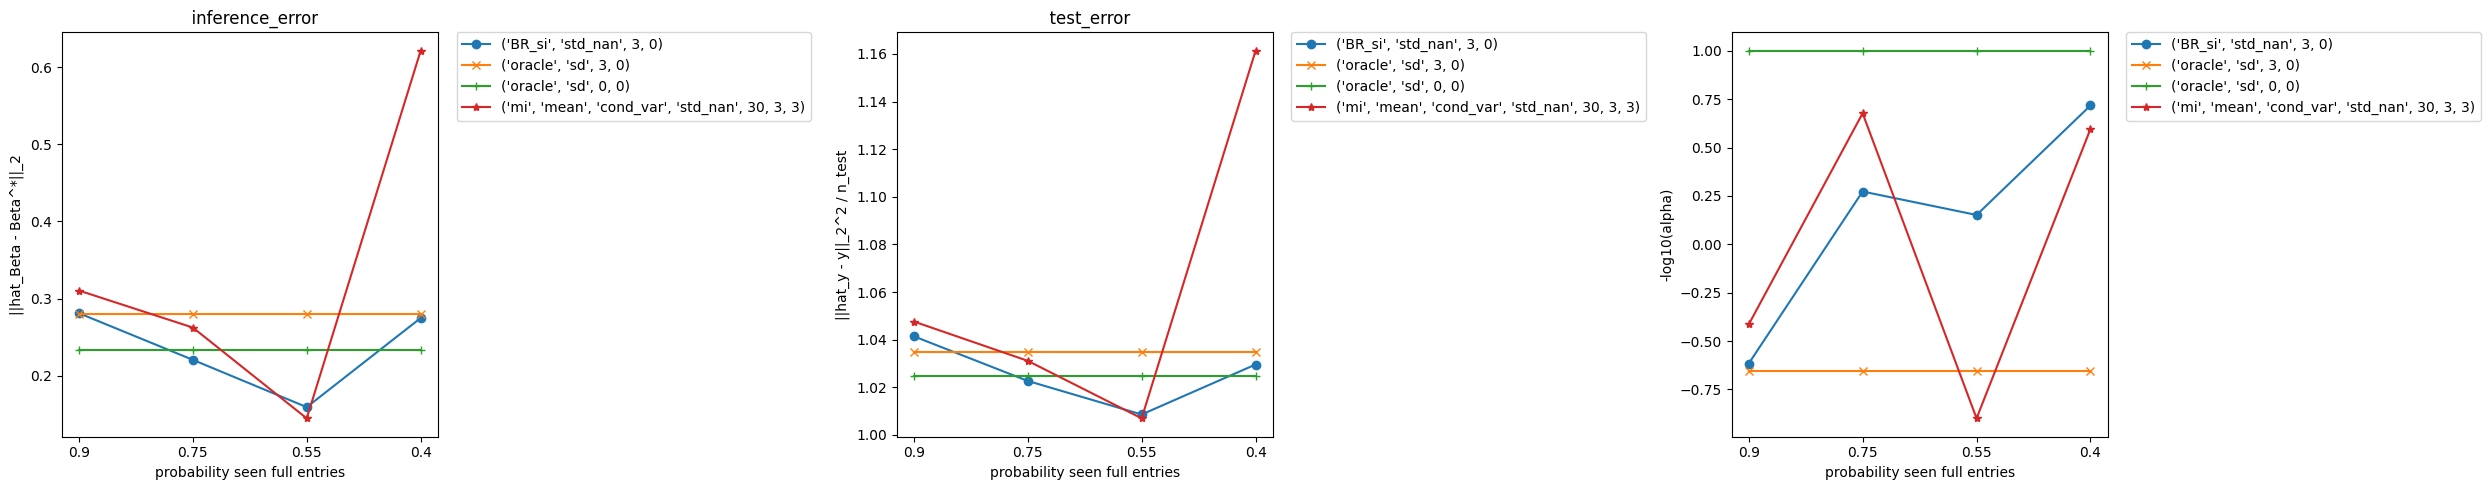

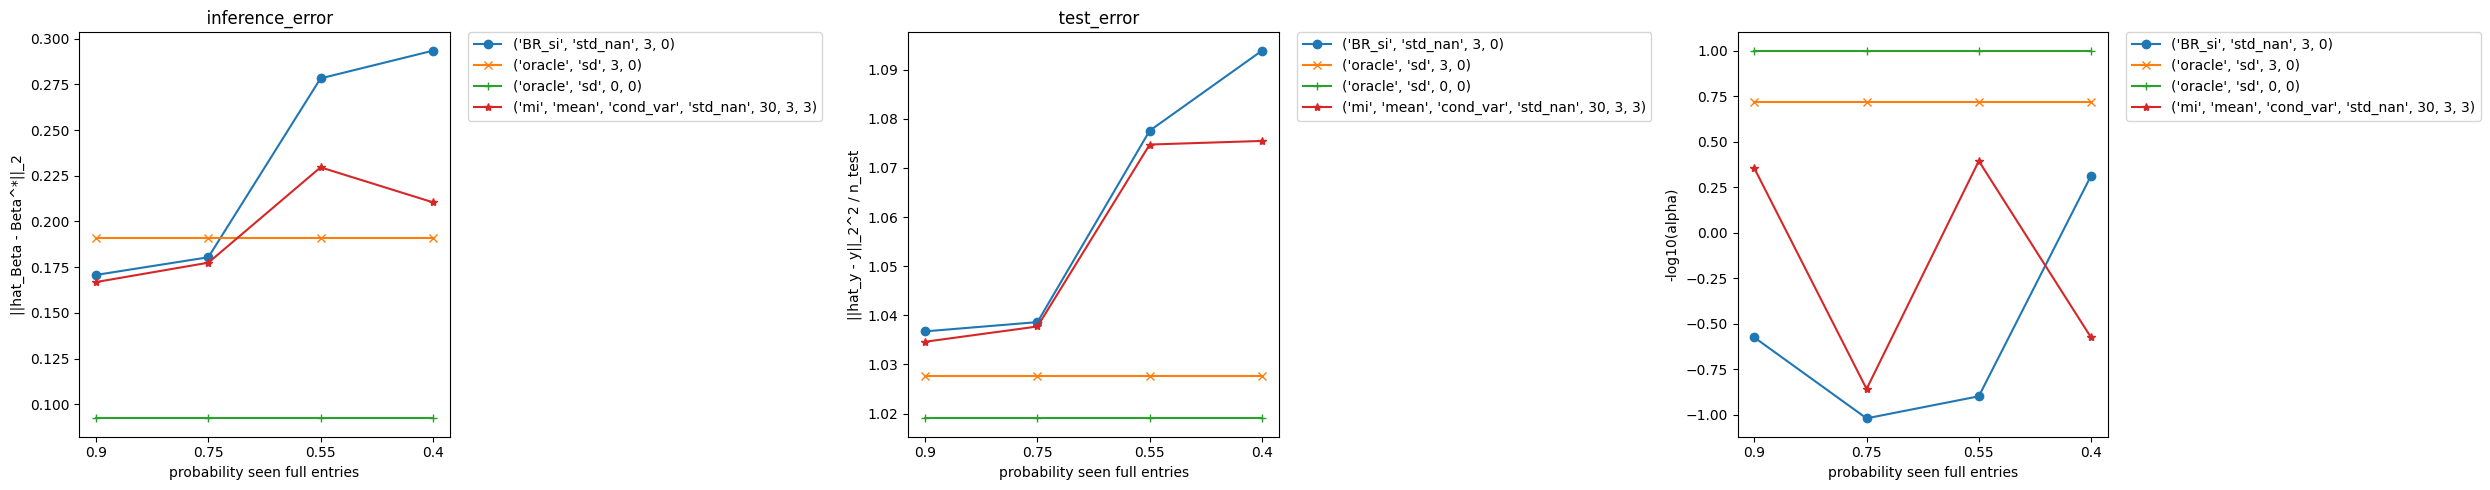

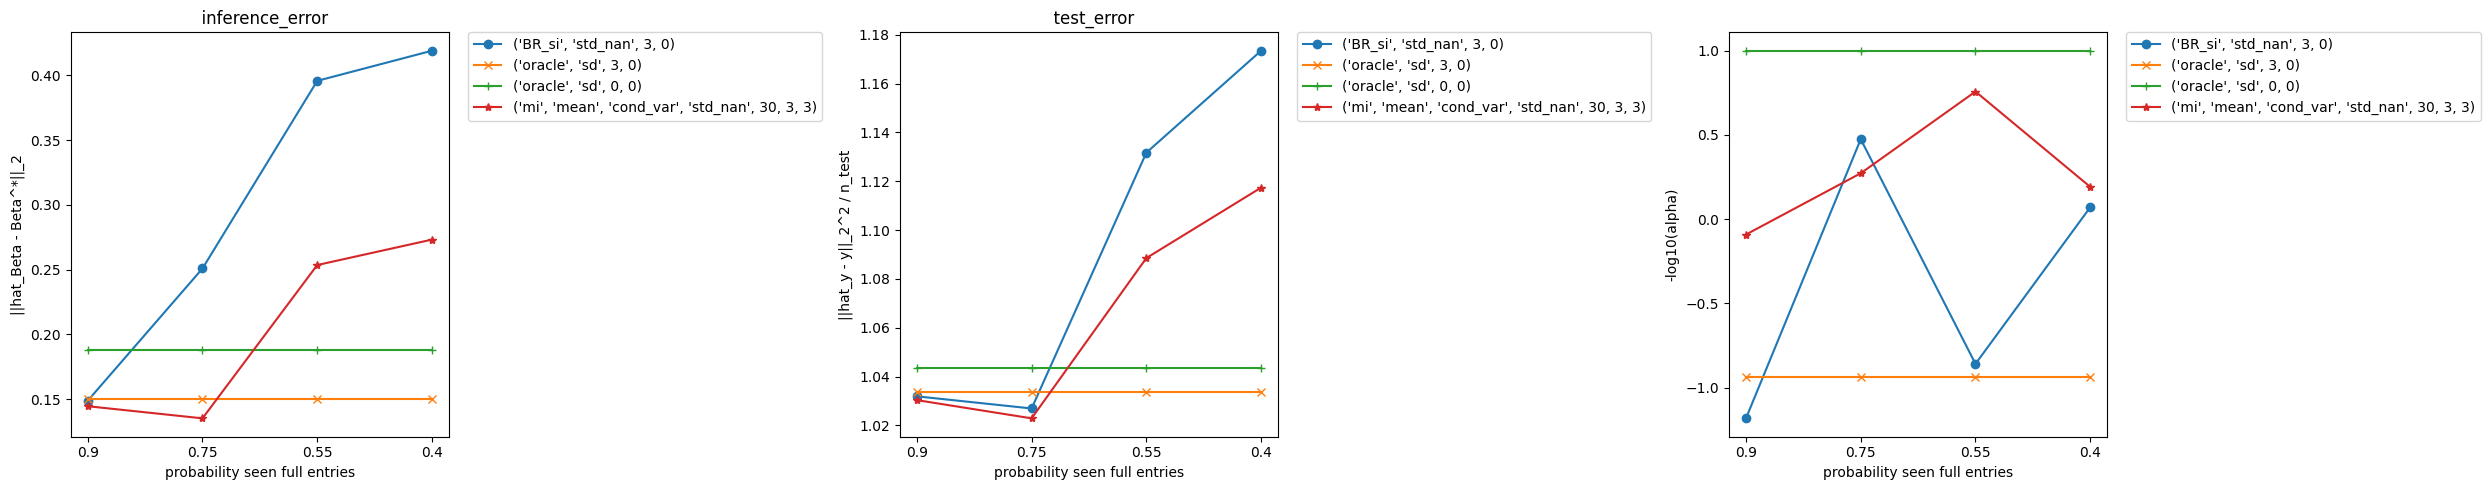

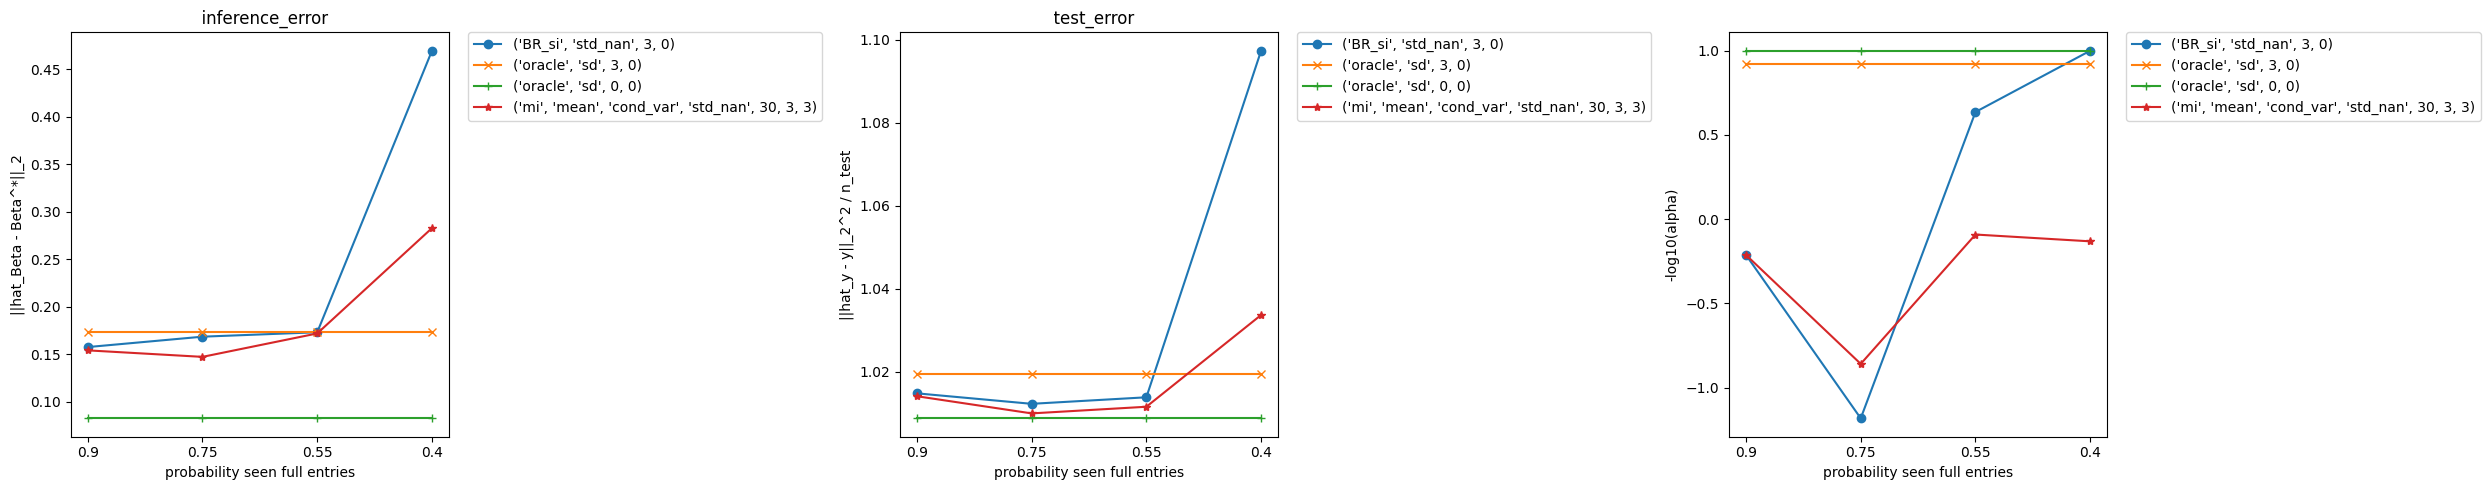

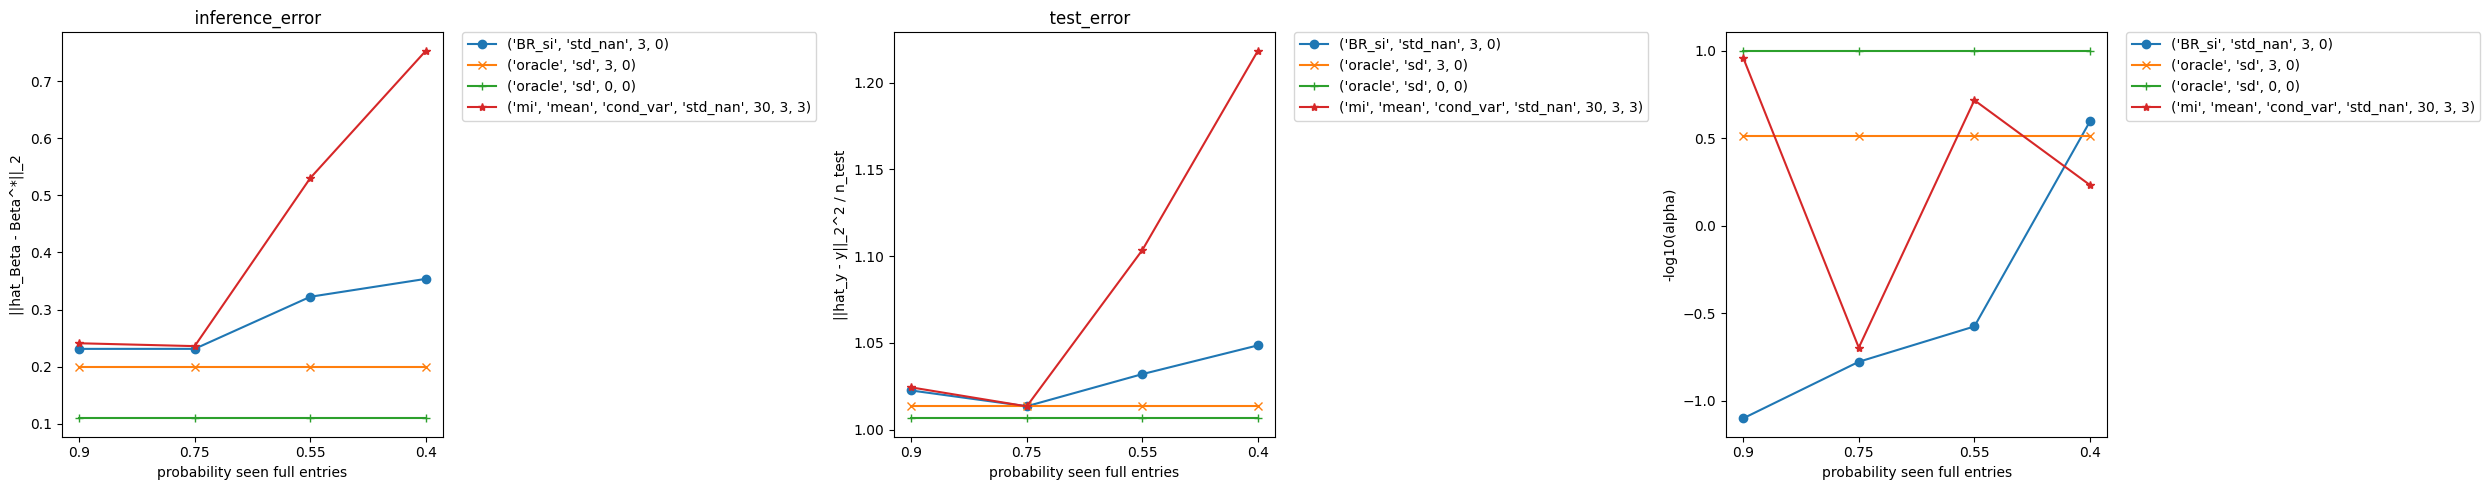

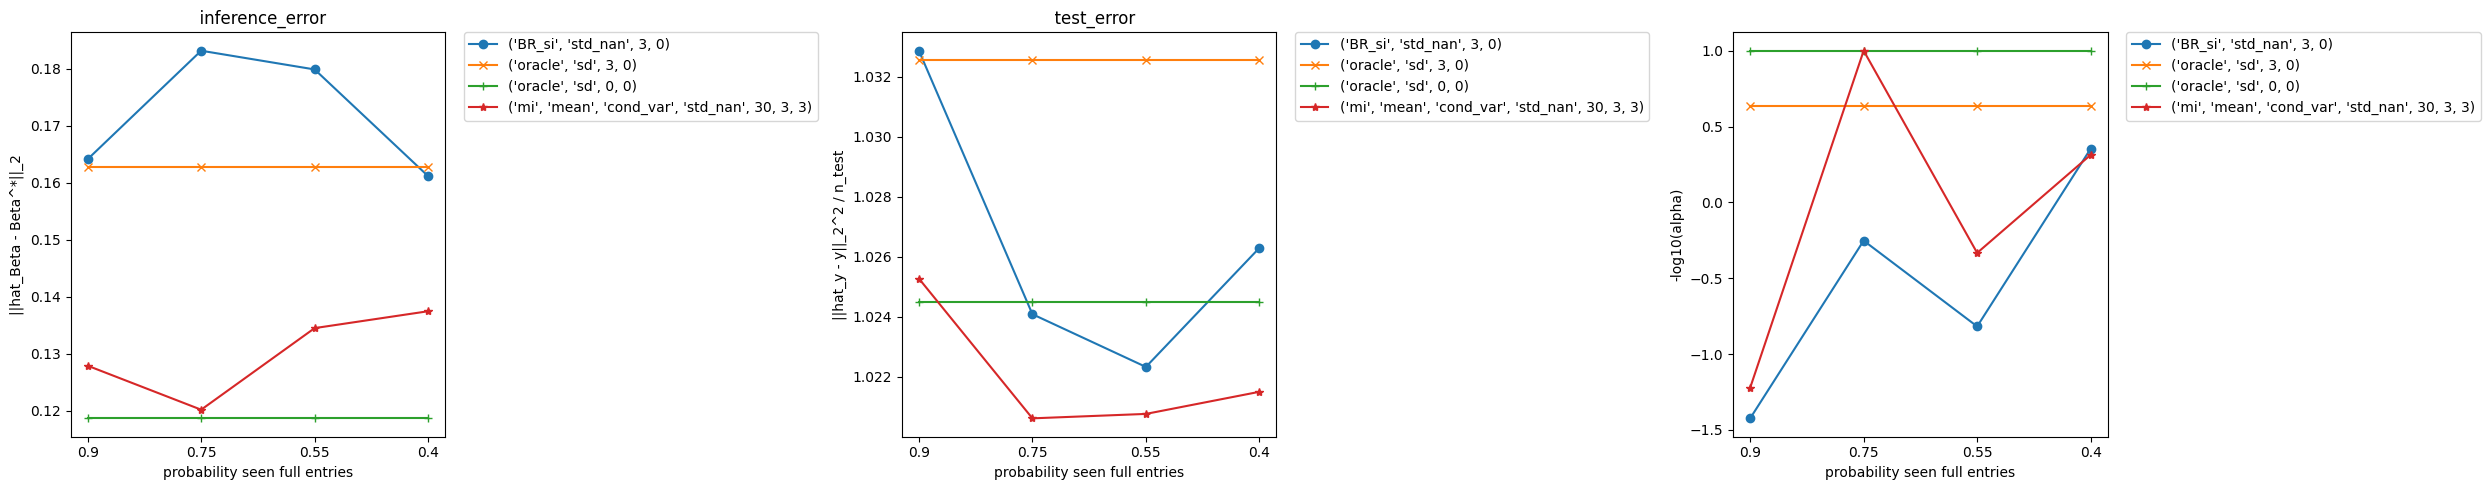

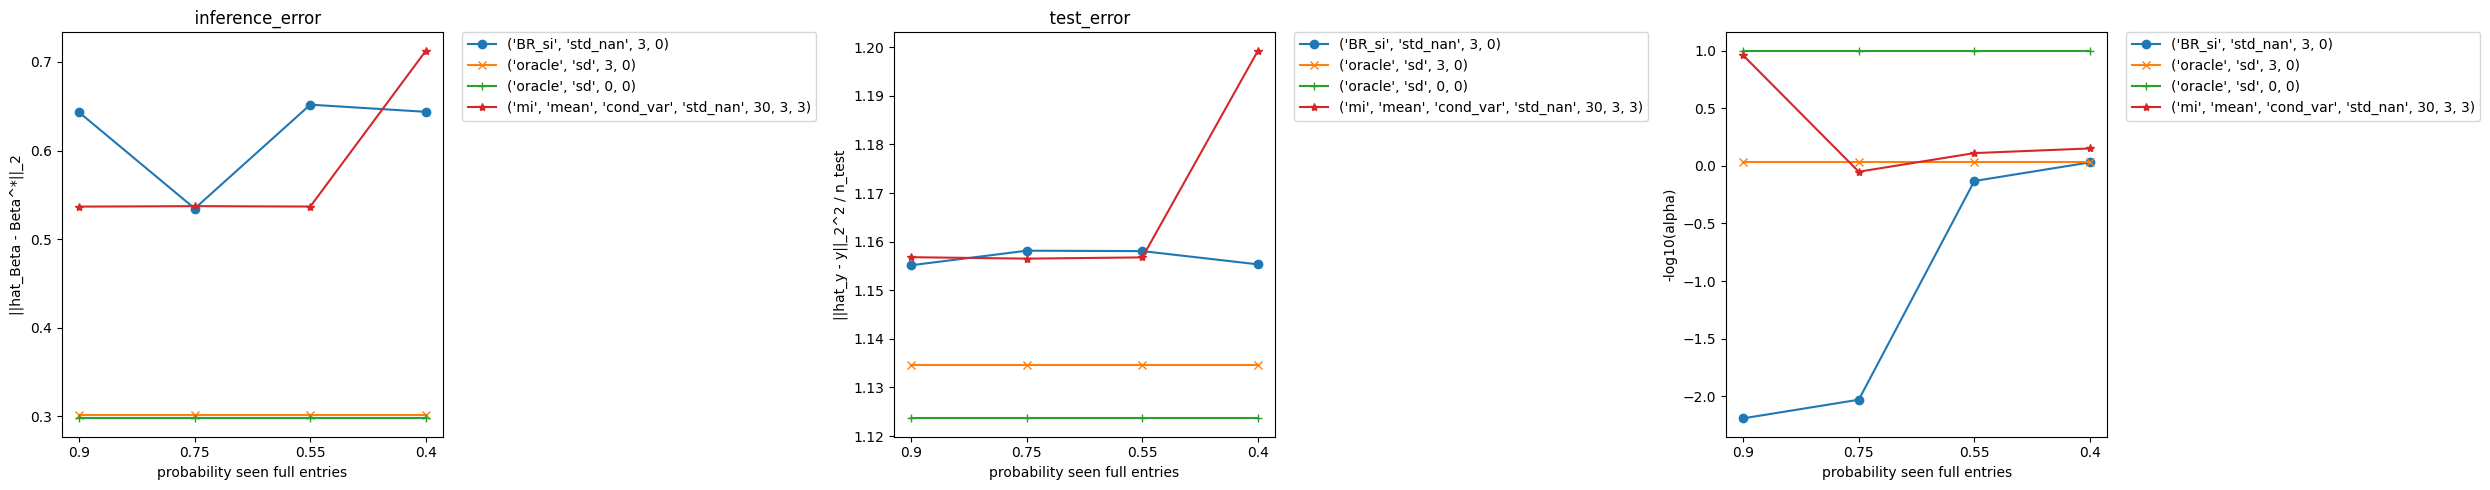

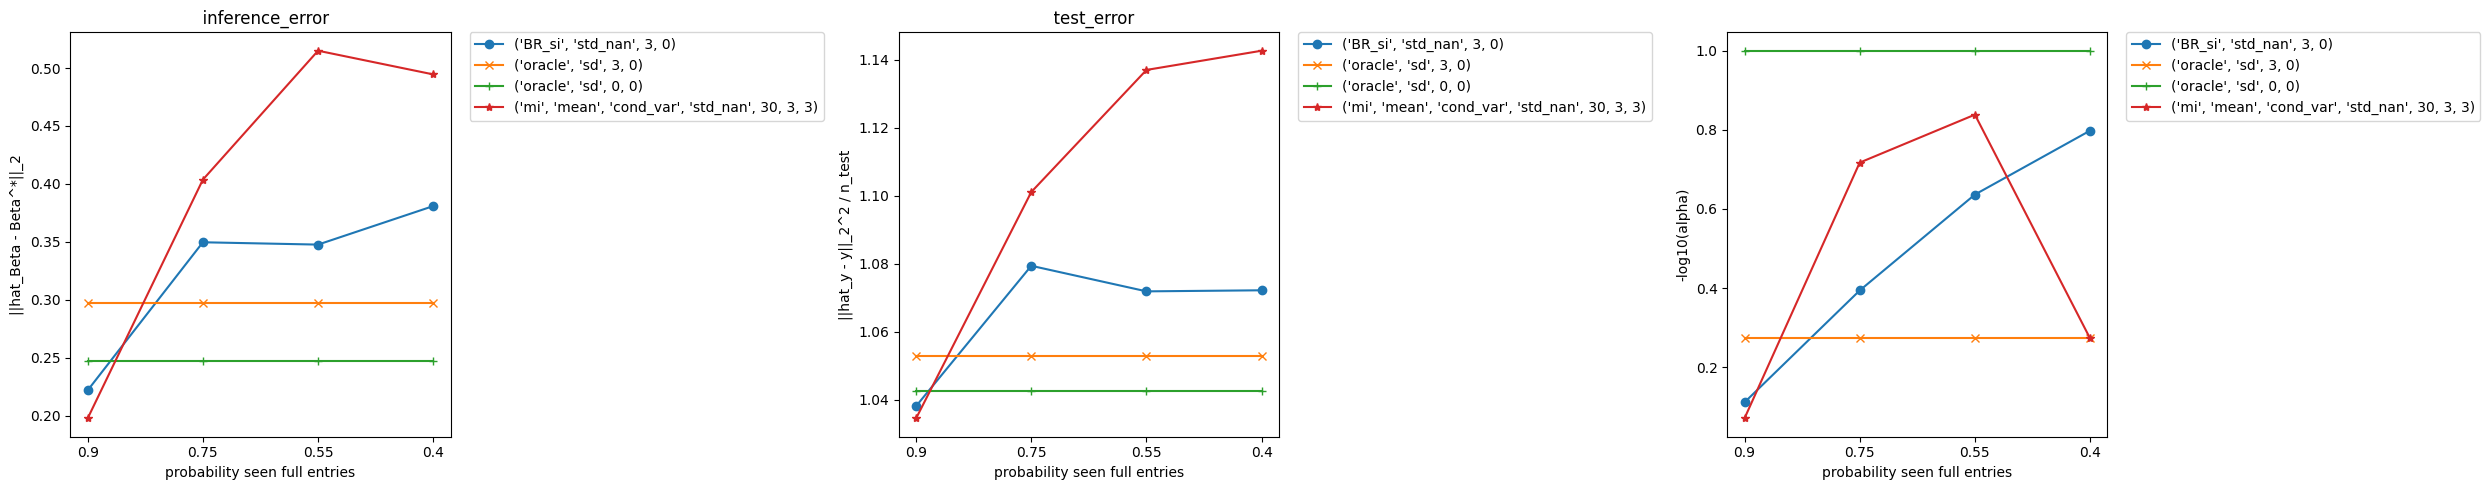

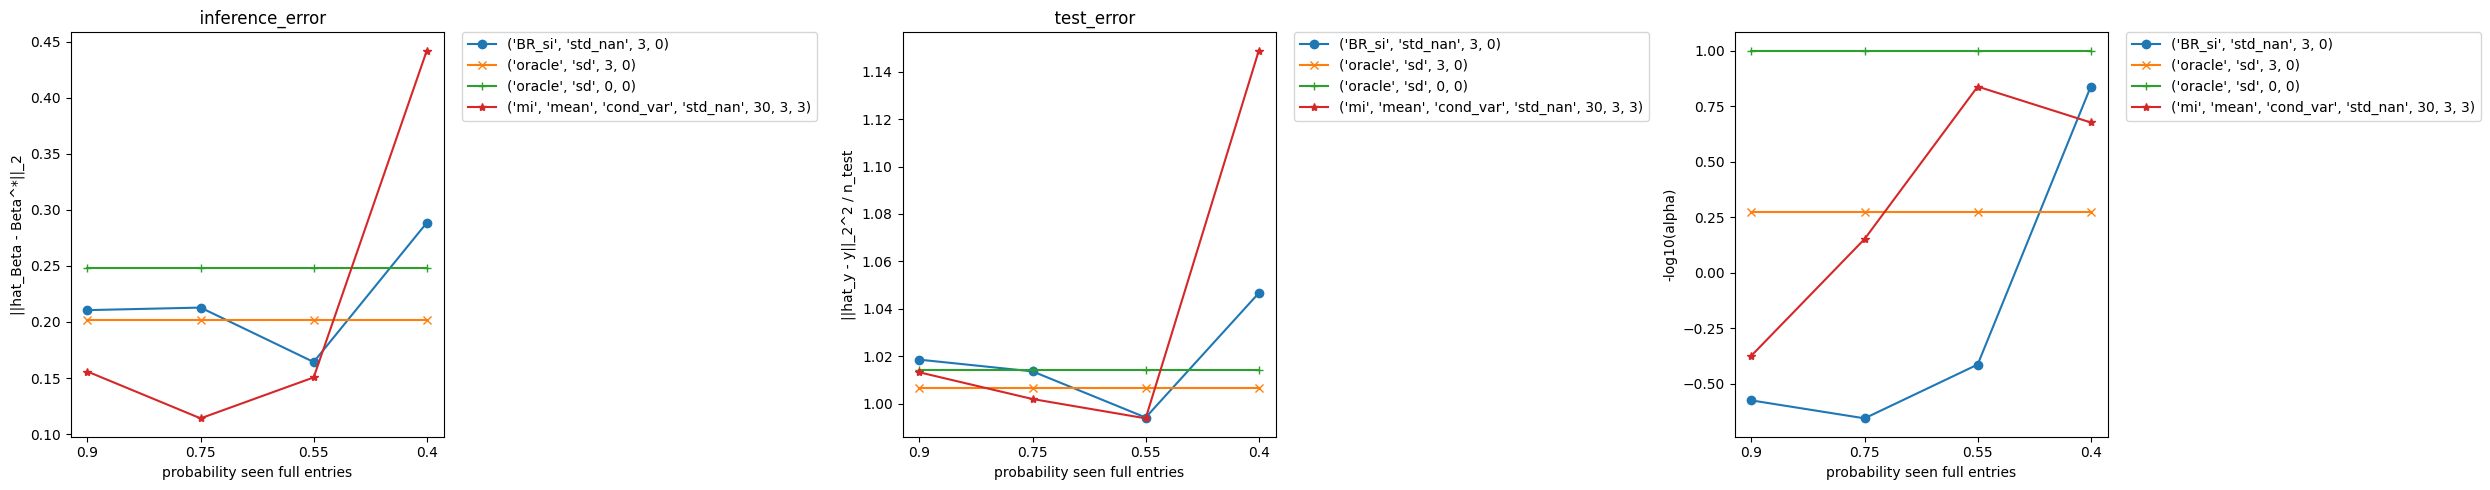

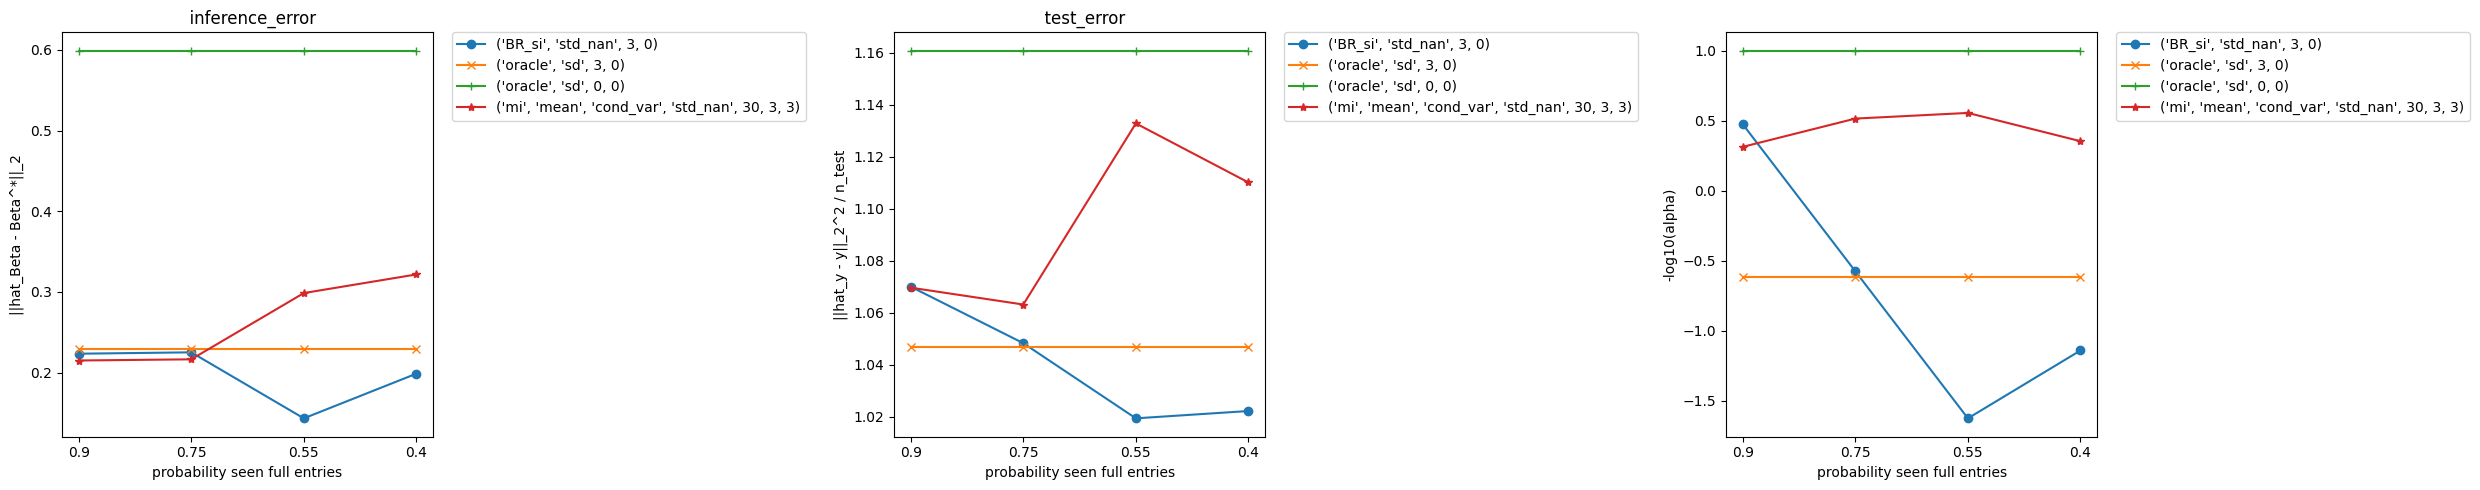

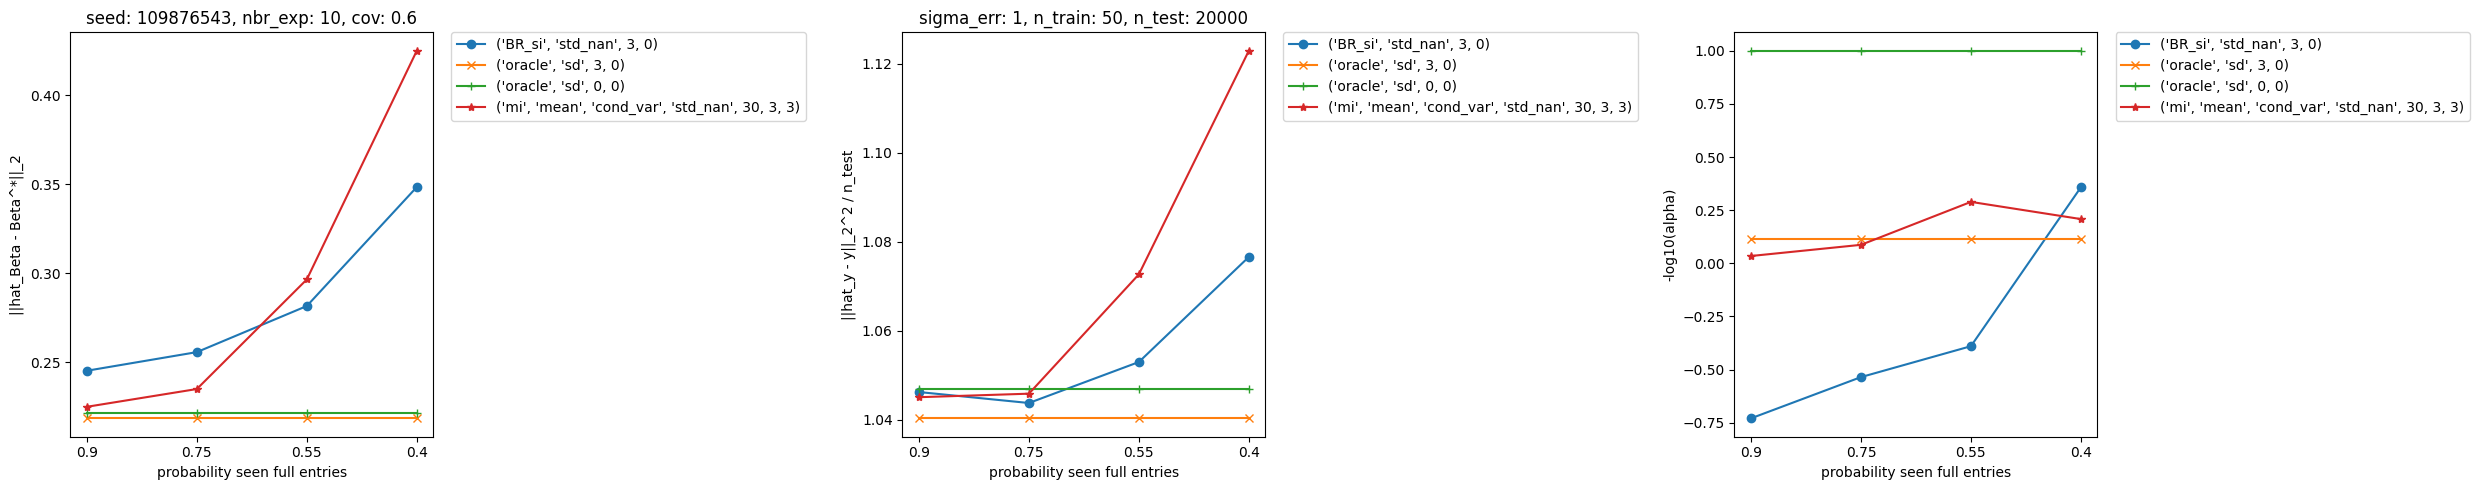

In [43]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [0.9, 0.75, 0.55, 0.4]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, cov_var], [cov_var, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation':gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 30
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 109876543
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
'''
np.random.seed(456789)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.1], [-0.1, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 30
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



## you can see if you manage to take the index i that maximize alpha
'''


In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]

